# HW3: Dueling Double DQN

## Preparation

This homework demands you to implement a DQN with some advanced tricks from RAINBOW:
* N-step target without off-policy correction
* Dueling Networks

Papers:
* DQN: https://arxiv.org/abs/1312.5602

* RAINBOW: https://arxiv.org/abs/1710.02298

* APE-X paper: https://arxiv.org/abs/1803.00933



You will run your agent on Atari Breakout environment: https://ale.farama.org/environments/breakout/

Atari docs: https://ale.farama.org/environments/

A paper about Atari benchmark in general: https://arxiv.org/abs/1709.06009

In [1]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash
    !wget -q https://raw.githubusercontent.com/laktionov/RL-course/2025/hw3/atari_wrappers.py
    !wget -q https://raw.githubusercontent.com/laktionov/RL-course/2025/hw3/utils.py
    !wget -q https://raw.githubusercontent.com/laktionov/RL-course/2025/hw3/framebuffer.py

    !pip -q install gymnasium[atari]==1.0.0

    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

In [2]:
%load_ext autoreload
%autoreload 2

We are using the latest version of Gymnasium

In [3]:
import gymnasium as gym
import random
import numpy as np
import torch
import matplotlib.pyplot as plt
import ale_py

gym.register_envs(ale_py)
%matplotlib inline

Let's play some old videogames. This time we're gonna apply approximate q-learning to an atari game called Breakout. It's not the hardest thing out there, but it's definitely way more complex than anything we tried before.

In [4]:
ENV_NAME = "ALE/Breakout-v5"

# Preprocessing

Let's see what observations look like.

A.L.E: Arcade Learning Environment (version 0.11.2+ecc1138)
[Powered by Stella]


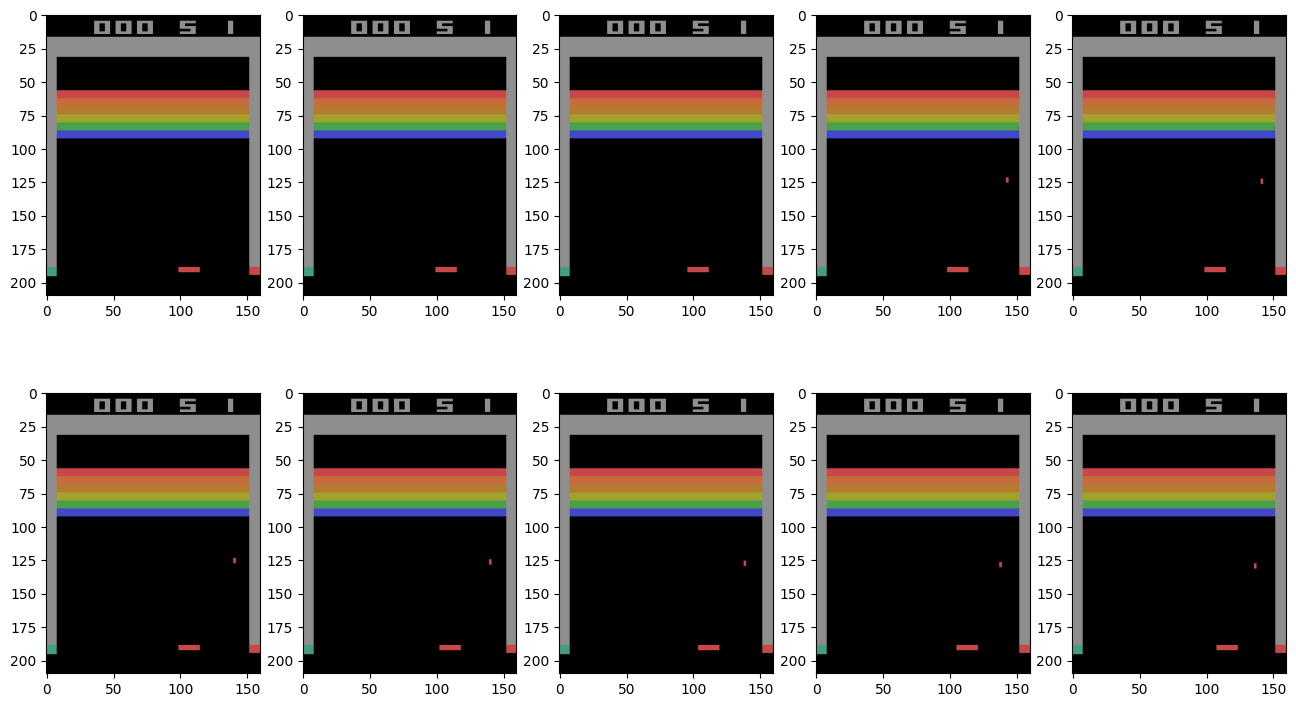

In [5]:
env = gym.make(ENV_NAME, render_mode="rgb_array",
               frameskip=1, repeat_action_probability=0.0)
env.reset()

n_cols = 5
n_rows = 2
fig = plt.figure(figsize=(16, 9))

for row in range(n_rows):
    for col in range(n_cols):
        ax = fig.add_subplot(n_rows, n_cols, row * n_cols + col + 1)
        ax.imshow(env.render())
        env.step(env.action_space.sample())
plt.show()

### Processing game image

Raw atari images are large, 210x160x3 by default. However, we don't need that level of detail in order to learn them.

We can thus save a lot of time by preprocessing game image, including
* Resizing to a smaller shape, 64 x 64
* Converting to grayscale
* Cropping irrelevant image parts (top, bottom and edges)

Also please keep one dimension for channel so that final shape would be 1 x 64 x 64.

Tip: You can implement your own grayscale converter and assign a huge weight to the red channel. This trick is not necessary but it will speed up learning.

In [6]:
from gymnasium import ObservationWrapper
from gymnasium.spaces import Box
import cv2


class PreprocessAtariObs(ObservationWrapper):
    def __init__(self, env):
        """A gym wrapper that crops, scales image into the desired shapes and grayscales it."""
        super().__init__(env)

        self.img_size = (1, 64, 64)
        self.observation_space = Box(0.0, 1.0, self.img_size)


    def _to_gray_scale(self, rgb, channel_weights=[0.8, 0.1, 0.1]):
        return np.dot(rgb[...,:3], channel_weights)[None, :, :]

    def observation(self, img):
        """what happens to each observation"""

        # Here's what you need to do:
        #  * crop image, remove irrelevant parts
        #  * resize image to self.img_size
        #     (use imresize from any library you want,
        #      e.g. opencv, skimage, PIL, keras)
        #  * cast image to grayscale
        #  * convert image pixels to (0,1) range, float32 type
        img = img[31:-17, 7:-8] # crop
        img = cv2.resize(img, (64, 64)) # resize
        img = self._to_gray_scale(img) # grayscale
        img = img.astype(np.float32) / 256 # float
        return img

Formal tests seem fine. Here's an example of what you'll get.


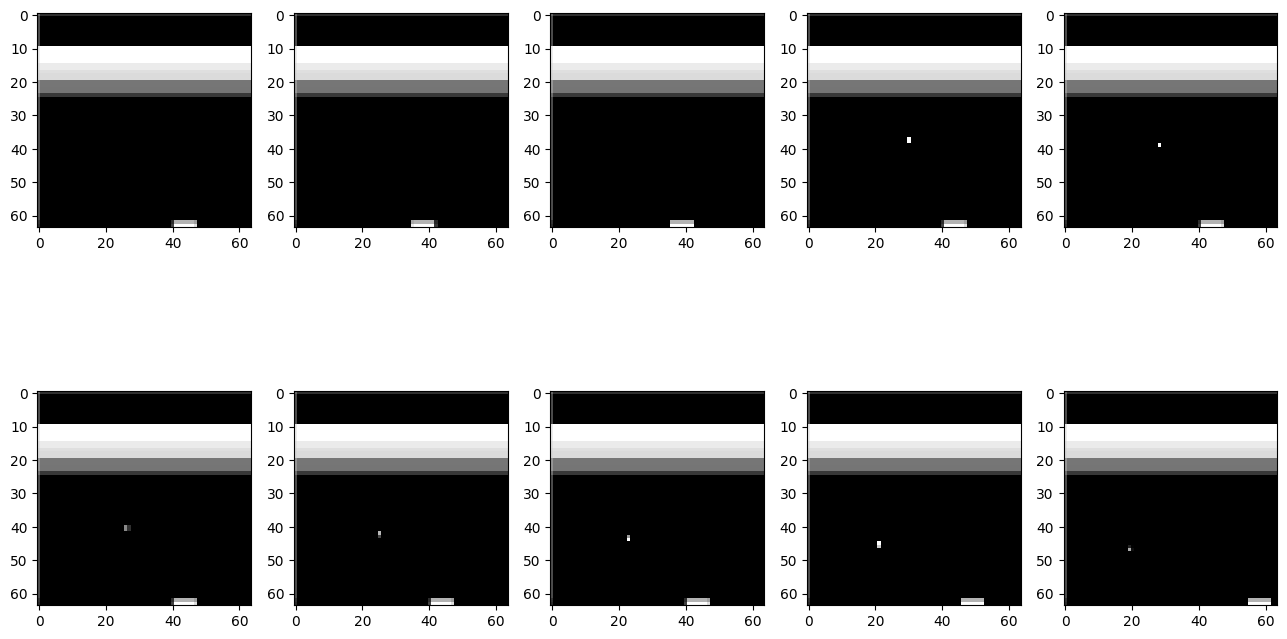

In [7]:
# spawn game instance for tests
env = gym.make(ENV_NAME, render_mode="rgb_array")  # create raw env
env = PreprocessAtariObs(env)
observation_shape = env.observation_space.shape
n_actions = env.action_space.n
env.reset()
obs, _, _, _, _ = env.step(env.action_space.sample())

# test observation
assert obs.ndim == 3, "observation must be [channel, h, w] even if there's just one channel"
assert obs.shape == observation_shape
assert obs.dtype == 'float32'
assert len(np.unique(obs)) > 2, "your image must not be binary"
assert 0 <= np.min(obs) and np.max(
    obs) <= 1, "convert image pixels to [0,1] range"
assert np.max(obs) > 1. / 256, "you probably divided on 256 twice"

print("Formal tests seem fine. Here's an example of what you'll get.")

n_cols = 5
n_rows = 2
fig = plt.figure(figsize=(16, 9))
obs, _ = env.reset()
for row in range(n_rows):
    for col in range(n_cols):
        ax = fig.add_subplot(n_rows, n_cols, row * n_cols + col + 1)
        ax.imshow(obs[0, :, :], interpolation='none', cmap='gray')
        obs, _, _, _, _ = env.step(env.action_space.sample())
plt.show()

# Wrapping

**About the game:** You have 5 lives and get points for breaking the wall. Higher bricks cost more than the lower ones. There are 4 actions: start game (should be called at the beginning and after each life is lost), move left, move right and do nothing. There are some common wrappers used for Atari environments.

In [8]:
import atari_wrappers

def PrimaryAtariWrap(env, clip_rewards=True):
    # This wrapper holds the same action for <skip> frames and outputs
    # the maximal pixel value of 2 last frames (to handle blinking
    # in some envs)
    env = atari_wrappers.MaxAndSkipEnv(env, skip=4)

    # This wrapper sends done=True when each life is lost
    # (not all the 5 lives that are givern by the game rules).
    # It should make easier for the agent to understand that losing is bad.
    env = atari_wrappers.EpisodicLifeEnv(env)

    # This wrapper laucnhes the ball when an episode starts.
    # Without it the agent has to learn this action, too.
    # Actually it can but learning would take longer.
    env = atari_wrappers.FireResetEnv(env)

    # This wrapper transforms rewards to {-1, 0, 1} according to their sign
    if clip_rewards:
        env = atari_wrappers.ClipRewardEnv(env)

    # This wrapper is yours :)
    env = PreprocessAtariObs(env)
    return env

# Frame Buffer

Our agent can only process one observation at a time, so we gotta make sure it contains enough information to find optimal actions. For instance, agent has to react to moving objects so he must be able to measure object's velocity. To do so, we introduce a buffer that stores 4 last images. This time everything is pre-implemented for you.

In [9]:
from framebuffer import FrameBuffer
import utils

def make_env(clip_rewards=True, seed=None):
    env = gym.make(ENV_NAME, render_mode="rgb_array")  # create raw env
    env = PrimaryAtariWrap(env, clip_rewards)
    env = FrameBuffer(env, n_frames=4, dim_order='pytorch')
    return env

env = make_env()
env.reset()
n_actions = env.action_space.n
state_shape = env.observation_space.shape
n_actions, state_shape

(np.int64(4), (4, 64, 64))

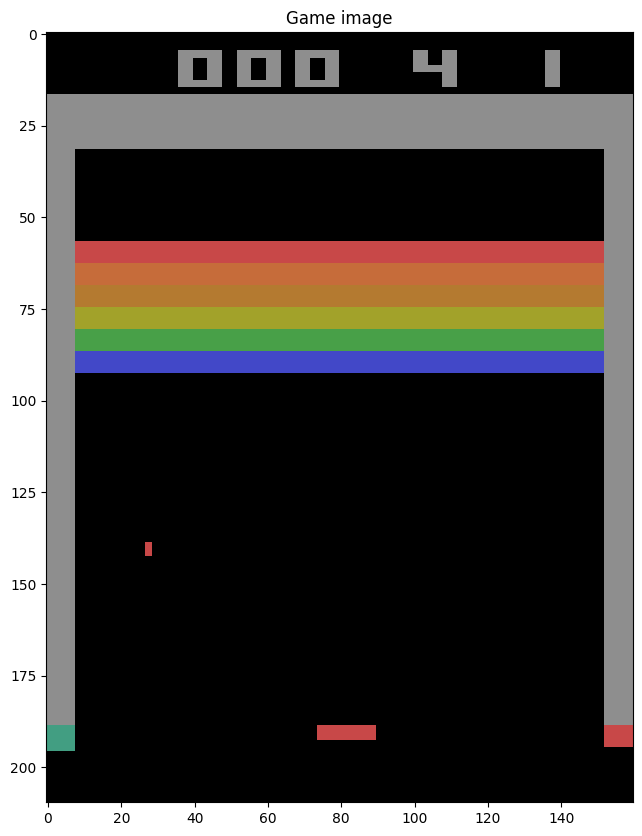

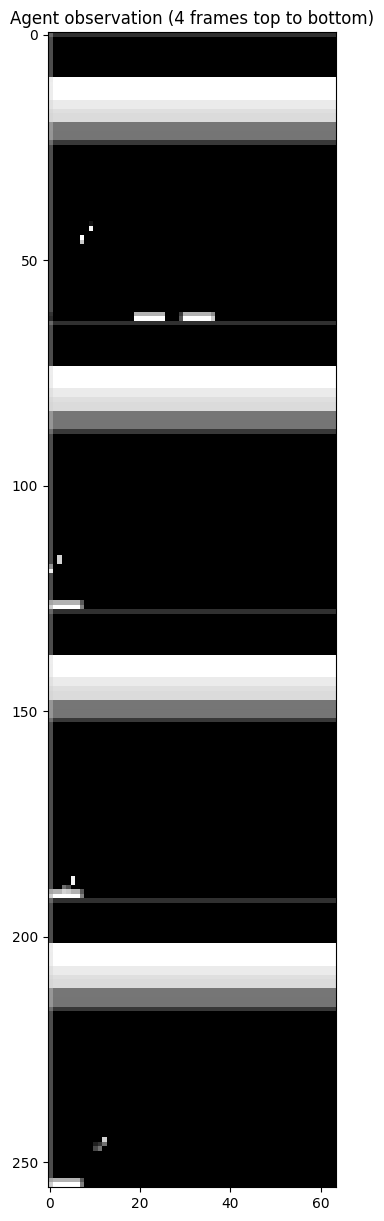

In [10]:
for _ in range(12):
    obs, _, _, _, _ = env.step(env.action_space.sample())

plt.figure(figsize=[12,10])
plt.title("Game image")
plt.imshow(env.render())
plt.show()

plt.figure(figsize=[15, 15])
plt.title("Agent observation (4 frames top to bottom)")
plt.imshow(utils.img_by_obs(obs, state_shape), cmap='gray')
plt.show()

# Dueling DDQN as it is


* Dueling network
* Replay buffer
* Double DQN with target network

### Dueling network (1 point)
Paper: https://arxiv.org/pdf/1511.06581.pdf
$$Q_{\theta}(s, a) = V_{\xi}(s) + A_{\psi}(s, a) - \frac{\sum_{a'}A_{\psi}(s, a')}{N_{actions}},$$

This is what it looks like:

Expects height=width=64

<!-- <img src="img/dueling_basic.png" alt="dueling_basic" width="500"/> -->
![img](https://github.com/yandexdataschool/Practical_RL/raw/master/week04_approx_rl/img/dueling_basic.png)

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# those who have a GPU but feel unfair to use it can uncomment:
# device = torch.device('cpu')
device

device(type='cuda')

In [12]:
from src.DQN import DuelingNetwork, conv2d_size_out, GradScalerFunctional, GradScaler, DQNAgent

Since both the advantage and the value stream propagate gradients to the last convolutional layer in the backward pass, we rescale the combined gradient entering the last convolutional layer by $\frac{1}{\sqrt{2}}$. This simple heuristic mildly increases stability.

In [13]:
agent = DQNAgent(state_shape, n_actions, epsilon=0.5).to(device)

Now let's try out our agent to see if it raises any errors.

In [14]:
DEBUG = False

def evaluate(env, agent, n_games=1, greedy=False, t_max=10000):
    """ Plays n_games full games. If greedy, picks actions as argmax(qvalues). Returns mean reward. """
    rewards = []
    for _ in range(n_games):
        s, _ = env.reset()
        reward = 0
        for _ in range(t_max):
            if DEBUG:
                print(s.shape)
            action = agent.sample_actions([s], greedy=greedy)[0]
            s, r, terminated, truncated, _ = env.step(action)
            reward += r
            if terminated or truncated:
                break

        rewards.append(reward)
    return np.mean(rewards)

In [15]:
evaluate(env, agent, n_games=1)

np.float64(1.0)

# Experience Replay

There's a powerful technique that you can use to improve sample efficiency for off-policy algorithms: Experience Replay. The catch is that you can train Q-learning and EV-SARSA on `<s,a,r,s'>` tuples even if they aren't sampled under current agent's policy. So here's what we're gonna do:

<img src=https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/exp_replay.png width=640>

#### Training with experience replay
1. Play game, sample `<s,a,r,s'>`.
2. Update q-values based on `<s,a,r,s'>`.
3. Store `<s,a,r,s'>` transition in a buffer.
 3. If buffer is full, delete earliest data.
4. Sample K such transitions from that buffer and update q-values based on them.

#### The interface is fairly simple:
* `exp_replay.add(obs, act, rw, next_obs, done)` - saves (s,a,r,s',done) tuple into the buffer
* `exp_replay.sample(batch_size)` - returns observations, actions, rewards, next_observations and is_done for `batch_size` random samples.
* `len(exp_replay)` - returns number of elements stored in replay buffer.


To enable such training, first we must implement a memory structure that would act like such a buffer.

In [16]:
from src.replay_buffer import ReplayBuffer

In [17]:

exp_replay = ReplayBuffer(10)

for _ in range(30):
    exp_replay.add(env.reset()[0], env.action_space.sample(),
                   1.0, env.reset()[0], done=False)

obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(
    5)

assert len(exp_replay) == 10, "experience replay size should be 10 because that's what maximum capacity is"

In [18]:
def play_and_record(initial_state, agent, env, exp_replay, n_steps=1):
    """
    Play the game for exactly n_steps, record every (s,a,r,s', done) to replay buffer.
    Whenever game ends, add record with done=True and reset the game.
    It is guaranteed that env has terminated=False when passed to this function.

    PLEASE DO NOT RESET ENV UNLESS IT IS "DONE"

    :returns: return sum of rewards over time and the state in which the env stays
    """
    s = initial_state
    sum_rewards = 0

    # Play the game for n_steps as per instructions above
    for _ in range(n_steps):
        action = agent.sample_actions([s])[0]
        next_s, r, terminated, truncated, _ = env.step(action)
        exp_replay.add(s, action, r, next_s, terminated)
        sum_rewards += r
        s = next_s
        if terminated or truncated:
            s, _ = env.reset()

    return sum_rewards, s

In [19]:
# testing your code.
exp_replay = ReplayBuffer(2000)

state, _ = env.reset()
play_and_record(state, agent, env, exp_replay, n_steps=1000)

# if you're using your own experience replay buffer, some of those tests may need correction.
# just make sure you know what your code does
assert len(exp_replay) == 1000, "play_and_record should have added exactly 1000 steps, "\
                                 "but instead added %i" % len(exp_replay)
is_dones = list(zip(*exp_replay._storage))[-1]

# assert 0 < np.mean(is_dones) < 0.1, "Please make sure you restart the game whenever it is 'done' and record the is_done correctly into the buffer."\
#                                     "Got %f is_done rate over %i steps. [If you think it's your tough luck, just re-run the test]" % (
#                                         np.mean(is_dones), len(exp_replay))

for _ in range(100):
    obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(10)
    assert obs_batch.shape == next_obs_batch.shape == (10,) + state_shape
    assert act_batch.shape == (10,), "actions batch should have shape (10,) but is instead %s" % str(act_batch.shape)
    assert reward_batch.shape == (10,), "rewards batch should have shape (10,) but is instead %s" % str(reward_batch.shape)
    assert is_done_batch.shape == (10,), "is_done batch should have shape (10,) but is instead %s" % str(is_done_batch.shape)
    assert [int(i) in (0, 1)
            for i in is_dones], "is_done should be strictly True or False"
    assert [0 <= a < n_actions for a in act_batch], "actions should be within [0, n_actions)"

print("Well done!")

Well done!


# Target networks

We also employ the so called "target network" - a copy of neural network weights to be used for reference Q-values:

The network itself is an exact copy of agent network, but it's parameters are not trained. Instead, they are moved here from agent's actual network every so often.

$$ Q_{reference}(s,a) = r + \gamma \cdot \max _{a'} Q_{target}(s',a') $$


<img src=https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/target_net.png width=640>

In [20]:
target_network = DQNAgent(agent.state_shape, agent.n_actions, epsilon=0.5).to(device)
# This is how you can load weights from agent into target network
target_network.load_state_dict(agent.state_dict())

<All keys matched successfully>

# Double DQN (1 point)

To prevent overestimation bias we also decouple action selection from action evaluation using agent's network and target network respectively.

$$ Q_{reference}(s,a) = r(s, a) + \gamma \cdot Q_{target}(s', argmax_{a'} Q_{
  \theta}(s', a')) $$

## Learning with... double Q-learning
Here we write a function similar to `agent.update` from tabular q-learning.

Compute Q-learning TD error:

$$ L = { 1 \over N} \sum_{(s, a)} [ Q_{\theta}(s,a) - Q_{reference}(s,a) ] ^2 $$

#### 1-step Q-reference defined as

$$ Q_{reference}(s,a) = r(s,a) + \gamma \cdot Q_{target}(s', argmax_{a'} Q_{\theta}(s', a')) $$

Where
* $Q_{target}(s',a')$ denotes q-value of next state and next action predicted by __target_network__
* $s, a, r, s'$ are current state, action, reward and next state respectively
* $\gamma$ is a discount factor defined two cells above.



__Note 1:__ there's an example input below. Feel free to experiment with it before you write the function.

__Note 2:__ compute_td_loss is a source of 99% of bugs in this homework. If reward doesn't improve, it often helps to go through it line by line [with a rubber duck](https://rubberduckdebugging.com/).


Sanity checks

In [21]:
from src.utils import compute_td_loss

obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(10)

loss = compute_td_loss(obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch,
                       agent, target_network,
                       gamma=0.99, check_shapes=True)
loss.backward()

assert loss.requires_grad and tuple(loss.data.size()) == (), "you must return scalar loss - mean over batch"
assert np.any(next(agent.parameters()).grad.data.cpu().numpy() != 0), "loss must be differentiable w.r.t. network weights"
assert np.all(next(target_network.parameters()).grad is None), "target network should not have grads"

In [22]:
obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(
    10)

loss = compute_td_loss(obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch,
                       agent, target_network,
                       gamma=0.99, check_shapes=True)
loss.backward()

assert loss.requires_grad and tuple(loss.data.size()) == (
    ), "you must return scalar loss - mean over batch"
assert np.any(next(agent.parameters()).grad.data.cpu().numpy() !=
              0), "loss must be differentiable w.r.t. network weights"
assert np.all(next(target_network.parameters()).grad is None), "target network should not have grads"

# Main loop (3 points)

It's time to put everything together and see if it learns anything.

In [23]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
from tqdm import trange
from src.DQN import DuelingNetwork, conv2d_size_out, GradScalerFunctional, GradScaler, DQNAgent
from IPython.display import clear_output
import matplotlib.pyplot as plt

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [24]:
env = make_env(seed)
state_shape = env.observation_space.shape
n_actions = env.action_space.n
state, _ = env.reset()

agent = DQNAgent(state_shape, n_actions, epsilon=1).to(device)
target_network = DQNAgent(state_shape, n_actions).to(device)
target_network.load_state_dict(agent.state_dict())

<All keys matched successfully>

Buffer of size $10^4$ fits into 5 Gb RAM.

Larger sizes ($10^5$ and $10^6$ are common) can be used. It can improve the learning, but $10^4$ is quiet enough. $10^2$ will probably fail learning.

In [25]:
exp_replay = ReplayBuffer(10**5)
for i in range(100):
    if not utils.is_enough_ram(min_available_gb=0.1):
        print("""
            Less than 100 Mb RAM available.
            Make sure the buffer size in not too huge.
            Also check, maybe other processes consume RAM heavily.
            """)
        break
    play_and_record(state, agent, env, exp_replay, n_steps=10**2)
    if len(exp_replay) == 10**4:
        break
print(len(exp_replay))

10000


In [26]:
timesteps_per_epoch = 1
batch_size = 32
total_steps = 3 * 10**6
decay_steps = 10**6

opt = torch.optim.Adam(agent.parameters(), lr=1e-4)

init_epsilon = 1
final_epsilon = 0.1

loss_freq = 50
refresh_target_network_freq = 5000
eval_freq = 5000

max_grad_norm = 50

n_lives = 5

In [27]:
mean_rw_history = []
td_loss_history = []
grad_norm_history = []
initial_state_v_history = []

In [28]:
# i allready trained agent before

agent.load_state_dict(torch.load("weights/19.0avg-basic-dqn-agent.pt"))
target_network.load_state_dict(torch.load("weights/19.0avg-basic-dqn-target.pt"))

<All keys matched successfully>

buffer size = 100000, epsilon = 0.40150


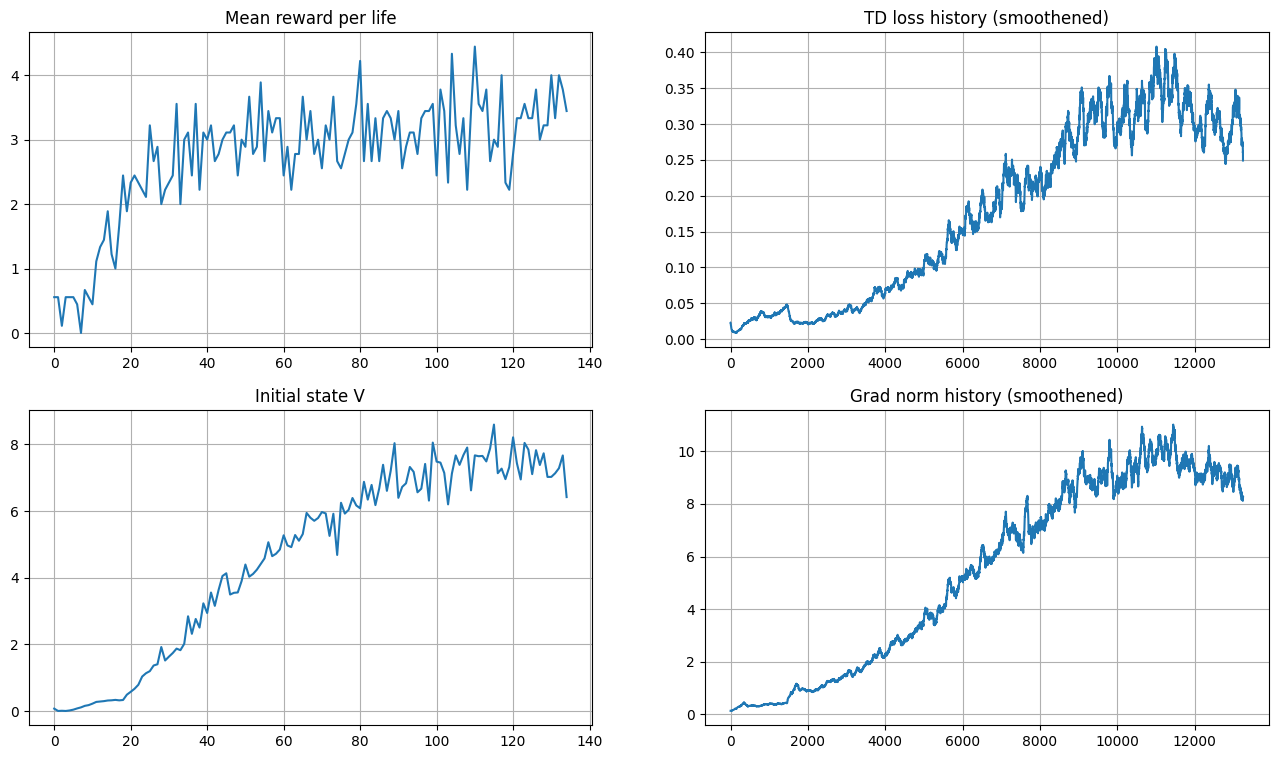

 22%|█████████████████▏                                                           | 667428/3000001 [1:33:56<5:28:18, 118.41it/s]


KeyboardInterrupt: 

In [51]:
state, _ = env.reset()
for step in trange(total_steps + 1):
    if not utils.is_enough_ram():
        print('less that 100 Mb RAM available, freezing')
        print('make sure everything is ok and make KeyboardInterrupt to continue')
        try:
            while True:
                pass
        except KeyboardInterrupt:
            pass

    agent.epsilon = utils.linear_decay(init_epsilon, final_epsilon, step, decay_steps)

    # play
    _, state = play_and_record(state, agent, env, exp_replay, timesteps_per_epoch)

    # train
    obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(batch_size)

    loss = compute_td_loss(obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch,
                          agent, target_network,
                          gamma=0.99)

    opt.zero_grad(set_to_none=True)
    loss.backward()
    grad_norm = nn.utils.clip_grad_norm_(agent.parameters(), max_grad_norm)
    opt.step()

    if step % loss_freq == 0:
        td_loss_history.append(loss.data.cpu().item())
        grad_norm_history.append(grad_norm.cpu().item())

    if step % refresh_target_network_freq == 0:
        # Load agent weights into target_network
        # <YOUR_CODE>
        target_network.load_state_dict(agent.state_dict())

    if step % eval_freq == 0:
        mean_rw_history.append(evaluate(
            make_env(clip_rewards=True, seed=step), agent, n_games=3 * 3, greedy=True)
        )
        initial_state_q_values = agent.get_qvalues(
            [make_env(seed=step).reset()[0]]
        )
        initial_state_v_history.append(np.max(initial_state_q_values))

        clear_output(True)
        print("buffer size = %i, epsilon = %.5f" %
              (len(exp_replay), agent.epsilon))

        plt.figure(figsize=[16, 9])

        plt.subplot(2, 2, 1)
        plt.title("Mean reward per life")
        plt.plot(mean_rw_history)
        plt.grid()

        assert not np.isnan(td_loss_history[-1])
        plt.subplot(2, 2, 2)
        plt.title("TD loss history (smoothened)")
        plt.plot(utils.smoothen(td_loss_history))
        plt.grid()

        plt.subplot(2, 2, 3)
        plt.title("Initial state V")
        plt.plot(initial_state_v_history)
        plt.grid()

        plt.subplot(2, 2, 4)
        plt.title("Grad norm history (smoothened)")
        plt.plot(utils.smoothen(grad_norm_history))
        plt.grid()
        plt.show()

График с гитхаба курса (Sergei Laktionov):

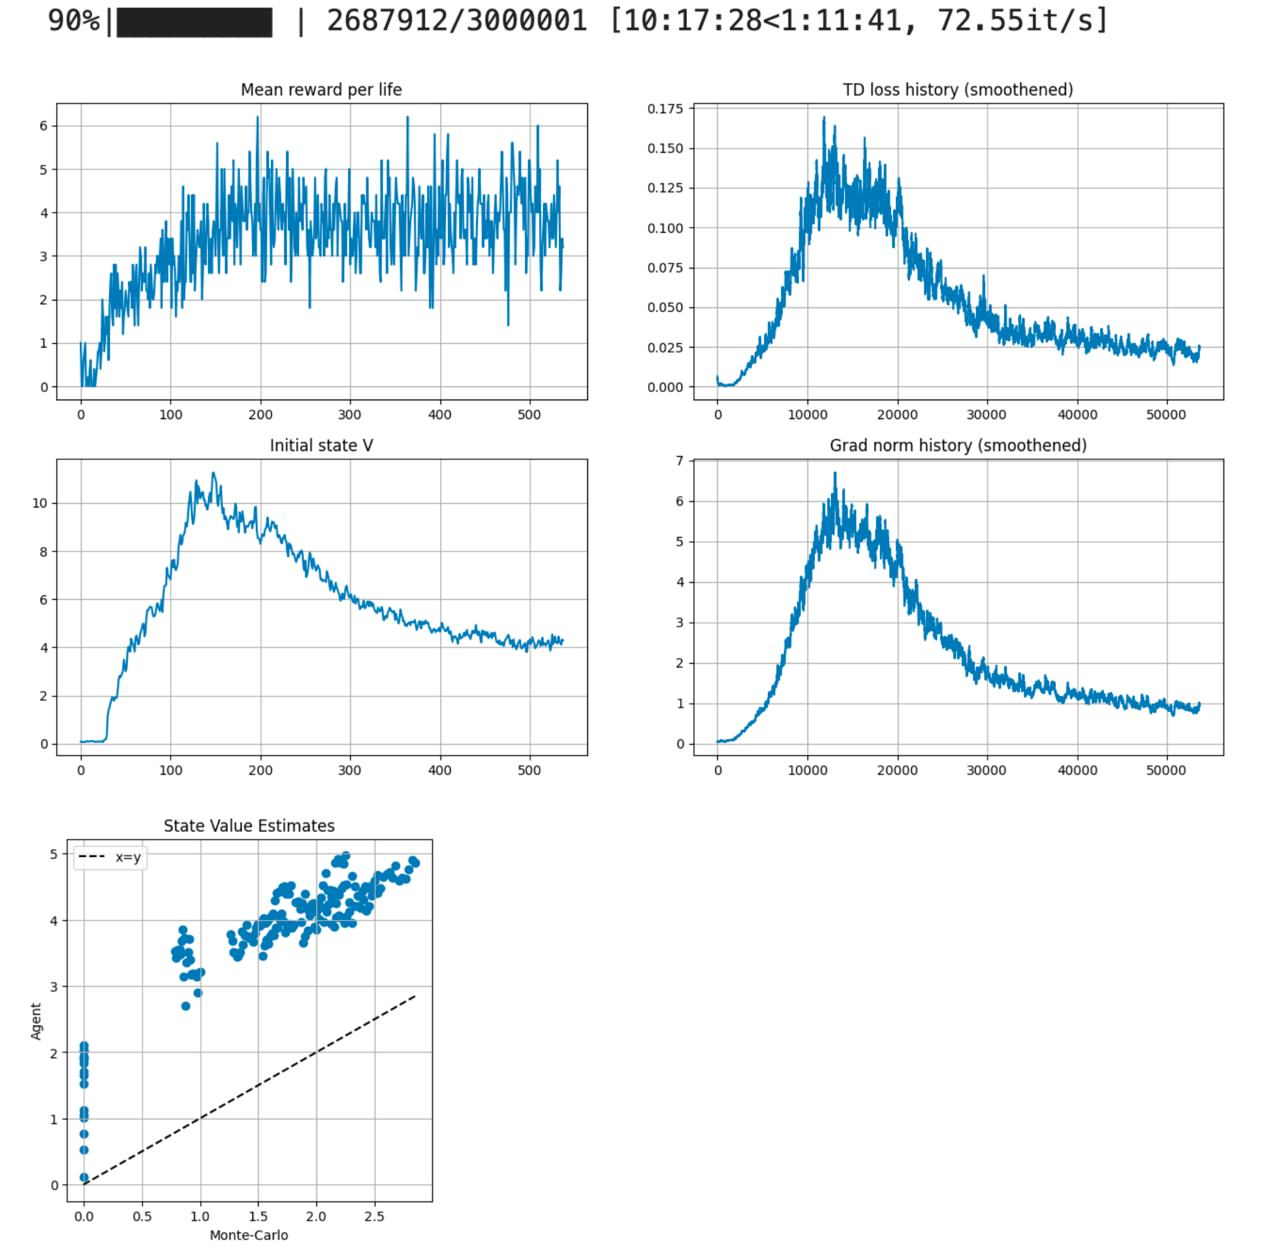

Мой график:

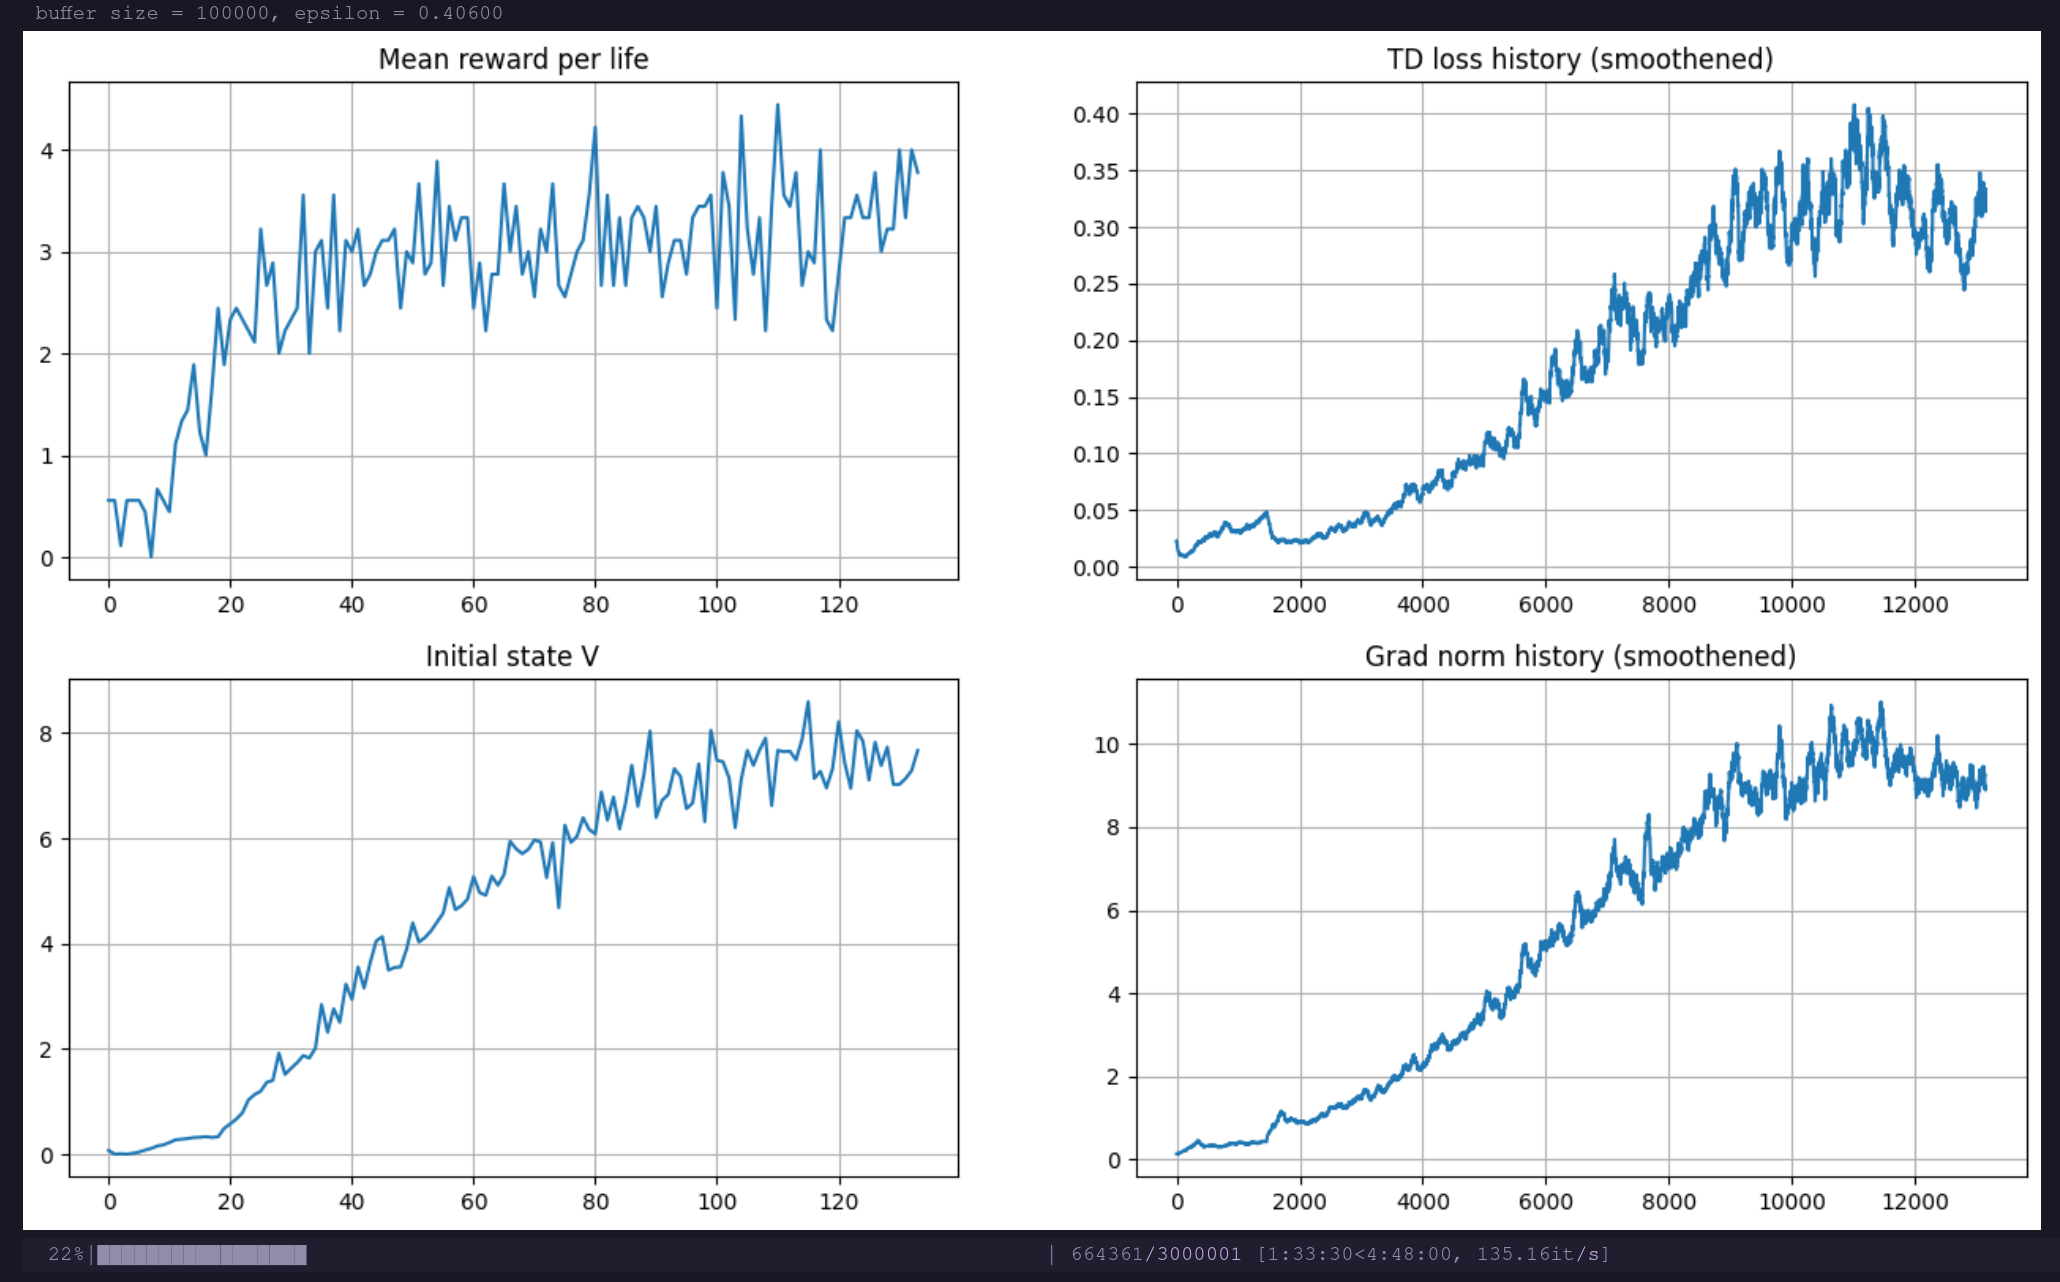

Agent is evaluated for 1 life, not for a whole episode of 5 lives. Rewards in evaluation are also truncated. Cuz this is what environment the agent is learning in and in this way mean rewards per life can be compared with initial state value

**The goal is to get 20 points in the real env**. So 4 points in the preprocessed one will probably be enough. You can interrupt learning then.

Final scoring is done on a whole episode with all 5 lives.

In [34]:
final_score = evaluate(
  make_env(clip_rewards=False, seed=9),
    agent, n_games=30, greedy=True, t_max=10 * 1000
) * n_lives
print('final score:', final_score)
assert final_score > 20, 'not as cool as DQN can'
print('Cool!')

final score: 21.333333333333332
Cool!


In [42]:
# torch.save(agent.state_dict(), "weights/19.0avg-basic-dqn-agent.pt")
# torch.save(target_network.state_dict(), "weights/19.0avg-basic-dqn-target.pt")

## How to interpret plots:

This aint no supervised learning so don't expect anything to improve monotonously.
* **TD loss** is the MSE between agent's current Q-values and target Q-values. It may slowly increase or decrease, it's ok. The "not ok" behavior includes going NaN or stayng at exactly zero before agent has perfect performance.
* **grad norm** just shows the intensivity of training. Not ok is growing to values of about 100 (or maybe even 50) though it depends on network architecture.
* **mean reward** is the expected sum of r(s,a) agent gets over the full game session. It will oscillate, but on average it should get higher over time (after a few thousand iterations...).
 * In basic q-learning implementation it takes about 40k steps to "warm up" agent before it starts to get better.
* **Initial state V** is the expected discounted reward for episode in the oppinion of the agent. It should behave more smoothly than **mean reward**. It should get higher over time but sometimes can experience drawdowns because of the agent's overestimates.
* **buffer size** - this one is simple. It should go up and cap at max size.
* **epsilon** - agent's willingness to explore. If you see that agent's already at 0.01 epsilon before it's average reward is above 0 - it means you need to increase epsilon. Set it back to some 0.2 - 0.5 and decrease the pace at which it goes down.
* Smoothing of plots is done with a gaussian kernel

At first your agent will lose quickly. Then it will learn to suck less and at least hit the ball a few times before it loses. Finally it will learn to actually score points.

**Training will take time.** A lot of it actually. Probably you will not see any improvment during first **150k** time steps (note that by default in this notebook agent is evaluated every 5000 time steps).

## About hyperparameters:

The task has something in common with supervised learning: loss is optimized through the buffer (instead of Train dataset). But the distribution of states and actions in the buffer **is not stationary** and depends on the policy that generated it. It can even happen that the mean TD error across the buffer is very low but the performance is extremely poor (imagine the agent collecting data to the buffer always manages to avoid the ball).

* Total timesteps and training time: It seems to be so huge, but actually it is normal for RL.

* $\epsilon$ decay shedule was taken from the original paper and is like traditional for epsilon-greedy policies. At the beginning of the training the agent's greedy policy is poor so many random actions should be taken.

* Optimizer: In the original paper RMSProp was used (they did not have Adam in 2013) and it can work not worse than Adam. For us Adam was default and it worked.

* lr: $10^{-3}$ would probably be too huge

* batch size: This one can be very important: if it is too small the agent can fail to learn. Huge batch takes more time to process. If batch of size 8 can not be processed on the hardware you use take 2 (or even 4) batches of size 4, divide the loss on them by 2 (or 4) and make optimization step after both backward() calls in torch.

* target network update frequency: has something in common with learning rate. Too frequent updates can lead to divergence. Too rare can lead to slow leraning. For millions of total timesteps thousands of inner steps seem ok. One iteration of target network updating is an iteration of the (this time approximate) $\gamma$-compression that stands behind Q-learning. The more inner steps it makes the more accurate is the compression.
* max_grad_norm - just huge enough. In torch clip_grad_norm also evaluates the norm before clipping and it can be convenient for logging.

# Record a video

In [58]:
# record sessions
from gymnasium.wrappers import RecordVideo

with RecordVideo(env=make_env(), video_folder='./videos',
                 episode_trigger = lambda episode_number: True) as env_monitor:
    sessions = [evaluate(env_monitor, agent, n_games=n_lives,
                         greedy=True) for _ in range(10)]
env.close()

/home/cloexec/Desktop/HSE/RL/rl-venv/lib/python3.10/site-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /home/cloexec/Desktop/HSE/RL/RL-HW/DQN/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [59]:
# Show video. This may not work in some setups. If it doesn't
# work for you, you can download the videos and view them locally.

from pathlib import Path
from base64 import b64encode
from IPython.display import HTML

video_paths = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])
video_path = video_paths[0]  # You can also try other indices

if 'google.colab' in sys.modules:
    # https://stackoverflow.com/a/57378660/1214547
    with video_path.open('rb') as fp:
        mp4 = fp.read()
    data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
else:
    data_url = str(video_path)

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(data_url))

# Let's have a closer look at this (up to 1 point)

Make a more complete record of an episode.

In [37]:
import matplotlib.pyplot as plt

In [36]:
eval_env = make_env(clip_rewards=False)
record = utils.play_and_log_episode(eval_env, agent)
print('total reward for life:', np.sum(record['rewards']))
for key in record:
    print(key)

total reward for life: 5.0
states
v_mc
v_agent
q_spreads
td_errors
rewards
episode_finished


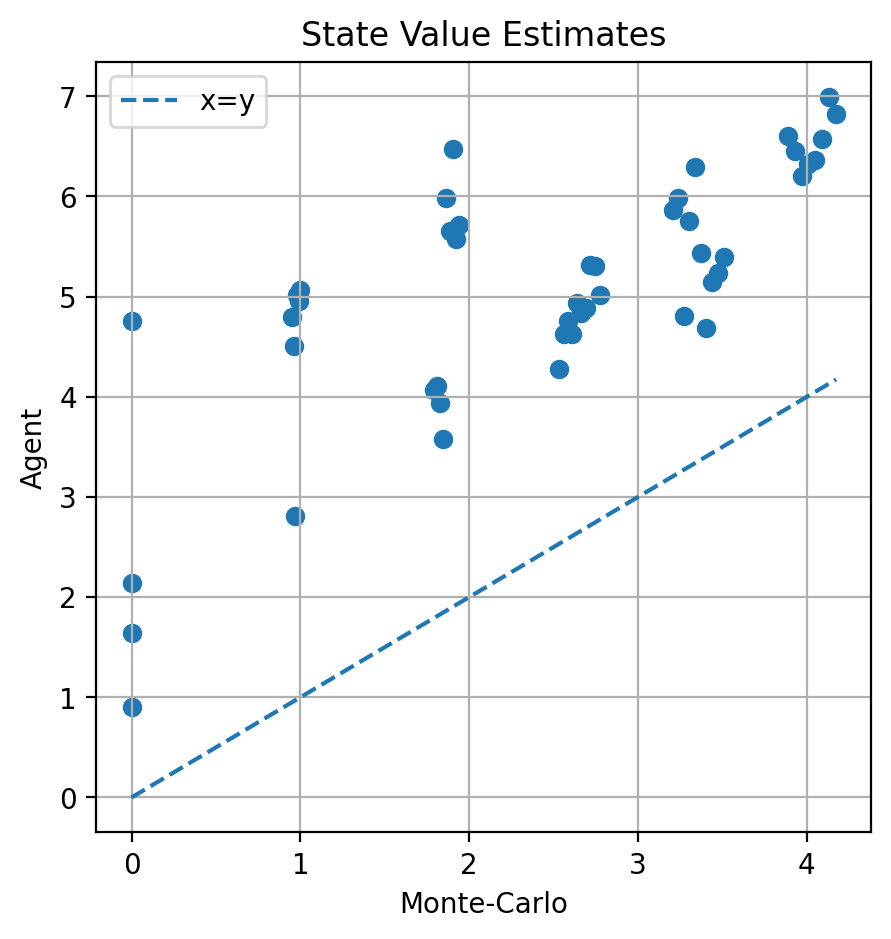

In [38]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)

ax.scatter(record['v_mc'], record['v_agent'])
ax.plot(sorted(record['v_mc']), sorted(record['v_mc']), linestyle='--', label='x=y')

ax.grid()
ax.legend()
ax.set_title('State Value Estimates')
ax.set_xlabel('Monte-Carlo')
ax.set_ylabel('Agent')

plt.show()

$\hat V_{Monte-Carlo}(s_t) = \sum_{\tau=0}^{episode~end} \gamma^{\tau-t}r_t$

Is there a big bias? It's ok, anyway it works.

Yes, bias is very big. But I didn't complete full training, and as we can see on plot from course gitub, value function goes down in the second half of training. 

**1.** Plot several (say 3) states with high and low spreads of Q estimate by actions i.e.
$$\max_a \hat Q(s,a) - \min_a \hat Q(s,a)\$$
Please take those states from different episodes to make sure that the states are really different.

What should high and low spread mean at least in the world of perfect Q-fucntions?

Comment the states you like most.

In [70]:
get_high_low(record, "q_spreads")

(32, 9)

In [66]:
from typing import Tuple

def get_high_low(record: dict, key: str) -> Tuple[int, int]:
    n = len(record[key])
    vals = list(zip(range(n), record[key]))
    vals = sorted(vals, key=lambda k: k[1])
    vals = list(filter(lambda x: x[0] > 4, vals))
    high, low = vals[-1][0], vals[0][0]
    return high, low

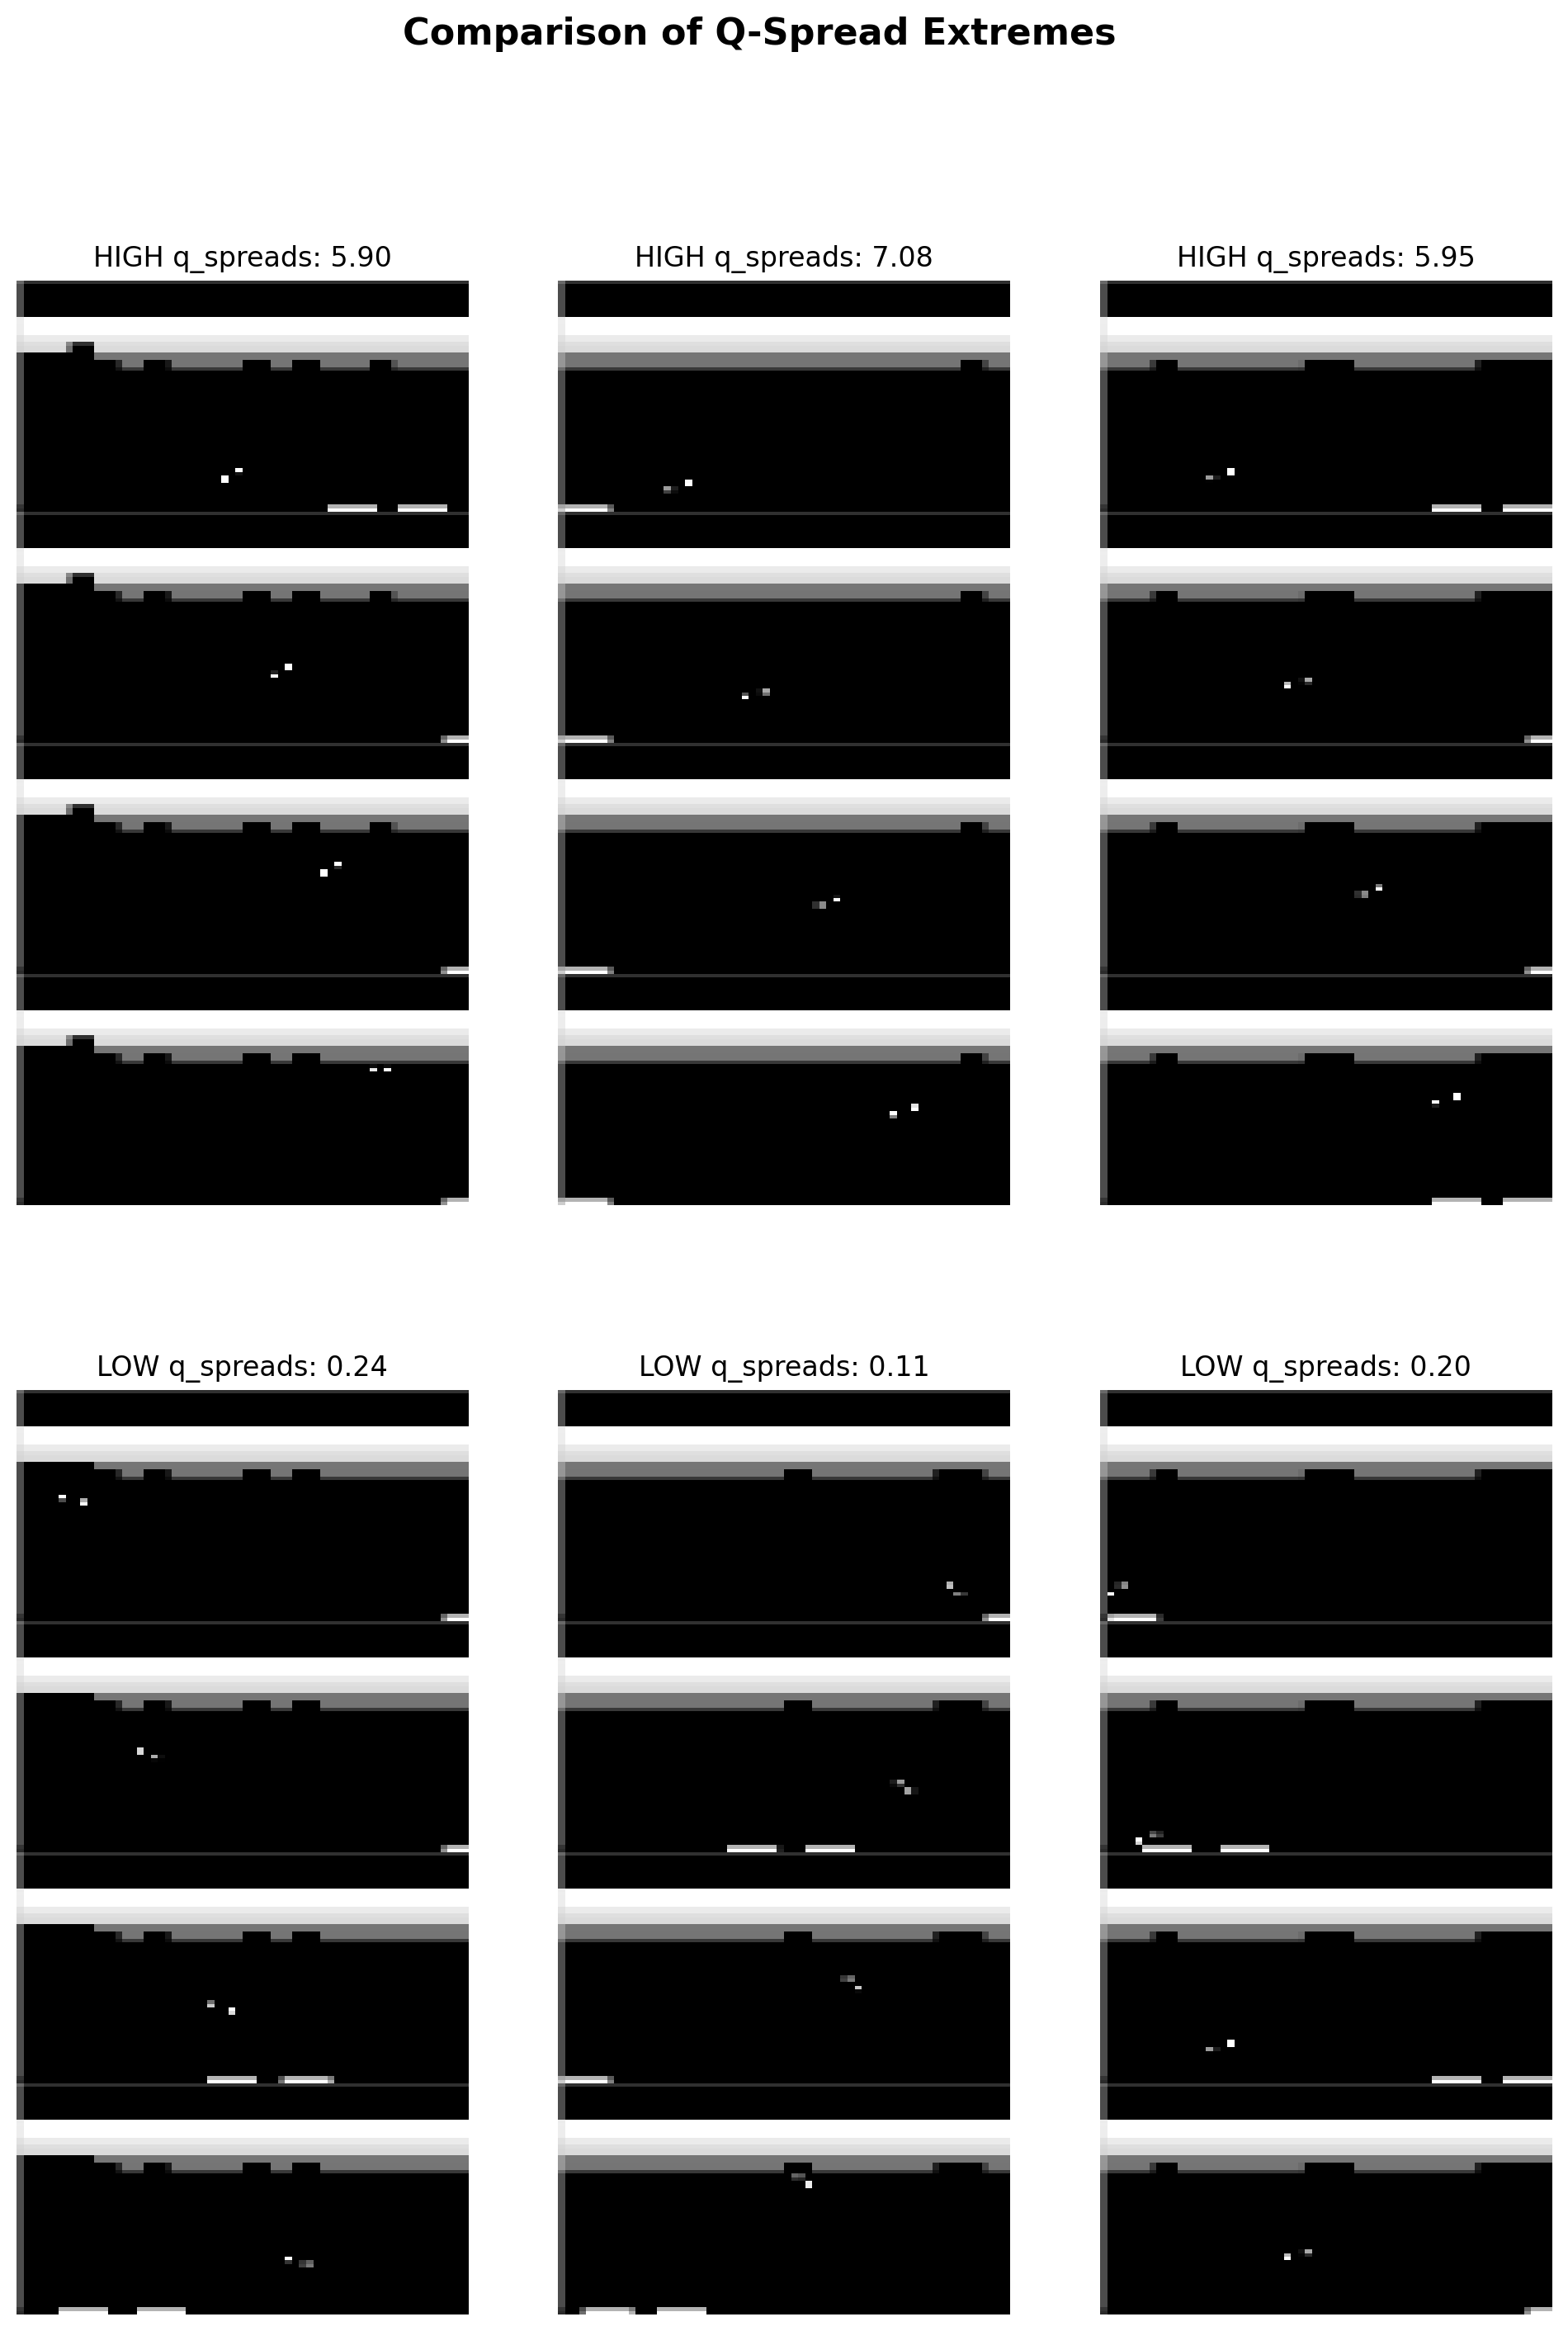

In [90]:
def plot_high_low(eval_env, agent, key, title: str):
    fig, axes = plt.subplots(2, 3, figsize=(12, 16))
    
    fig.suptitle(title, fontsize=16, fontweight='bold')
    for i in range(3):
        rec = utils.play_and_log_episode(eval_env, agent)
        while len(rec[key]) < 4:
            rec = utils.play_and_log_episode(eval_env, agent)
        high_idx, low_idx = get_high_low(rec, key)
        
        high_obs, low_obs = rec['states'][high_idx], rec['states'][low_idx]
        high_val, low_val = rec[key][high_idx], rec[key][low_idx]
        
        axes[0, i].imshow(utils.img_by_obs(high_obs, state_shape), cmap='gray', aspect='auto')
        axes[0, i].set_title(f"HIGH {key}: {high_val:.2f}")
        
        axes[1, i].imshow(utils.img_by_obs(low_obs, state_shape), cmap='gray', aspect='auto')
        axes[1, i].set_title(f"LOW {key}: {low_val:.2f}")
        
        axes[0, i].axis('off')
        axes[1, i].axis('off')
    # plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
plot_high_low(eval_env, agent, "q_spreads", "Comparison of Q-Spread Extremes")

На картинках видно, что high spread там, где нужно срочно спасать мяч и быстро двигаться к нужной позиции.

Low spread там, где летит от нас, либо мы уже в правильной позиции и любое отклонение от нее можно будет вернуть обратно. Также в ситуации, где мы уже проиграли тоже будет Low Spread.

**2.** Plot several (say 3) states with high td-error and several states with high values of
$$| \hat V_{Monte-Carlo}(s) - \hat V_{agent}(s)|,$$
$$\hat V_{agent}(s) = \max_a \hat Q(s,a).$$

Please take those states from different episodes to make sure that the states are really different. From what part (i.e. beginning, middle, end) of an episode did these states come from?

Comment the states you like most.

In [91]:
record.keys()

dict_keys(['states', 'v_mc', 'v_agent', 'q_spreads', 'td_errors', 'rewards', 'episode_finished'])

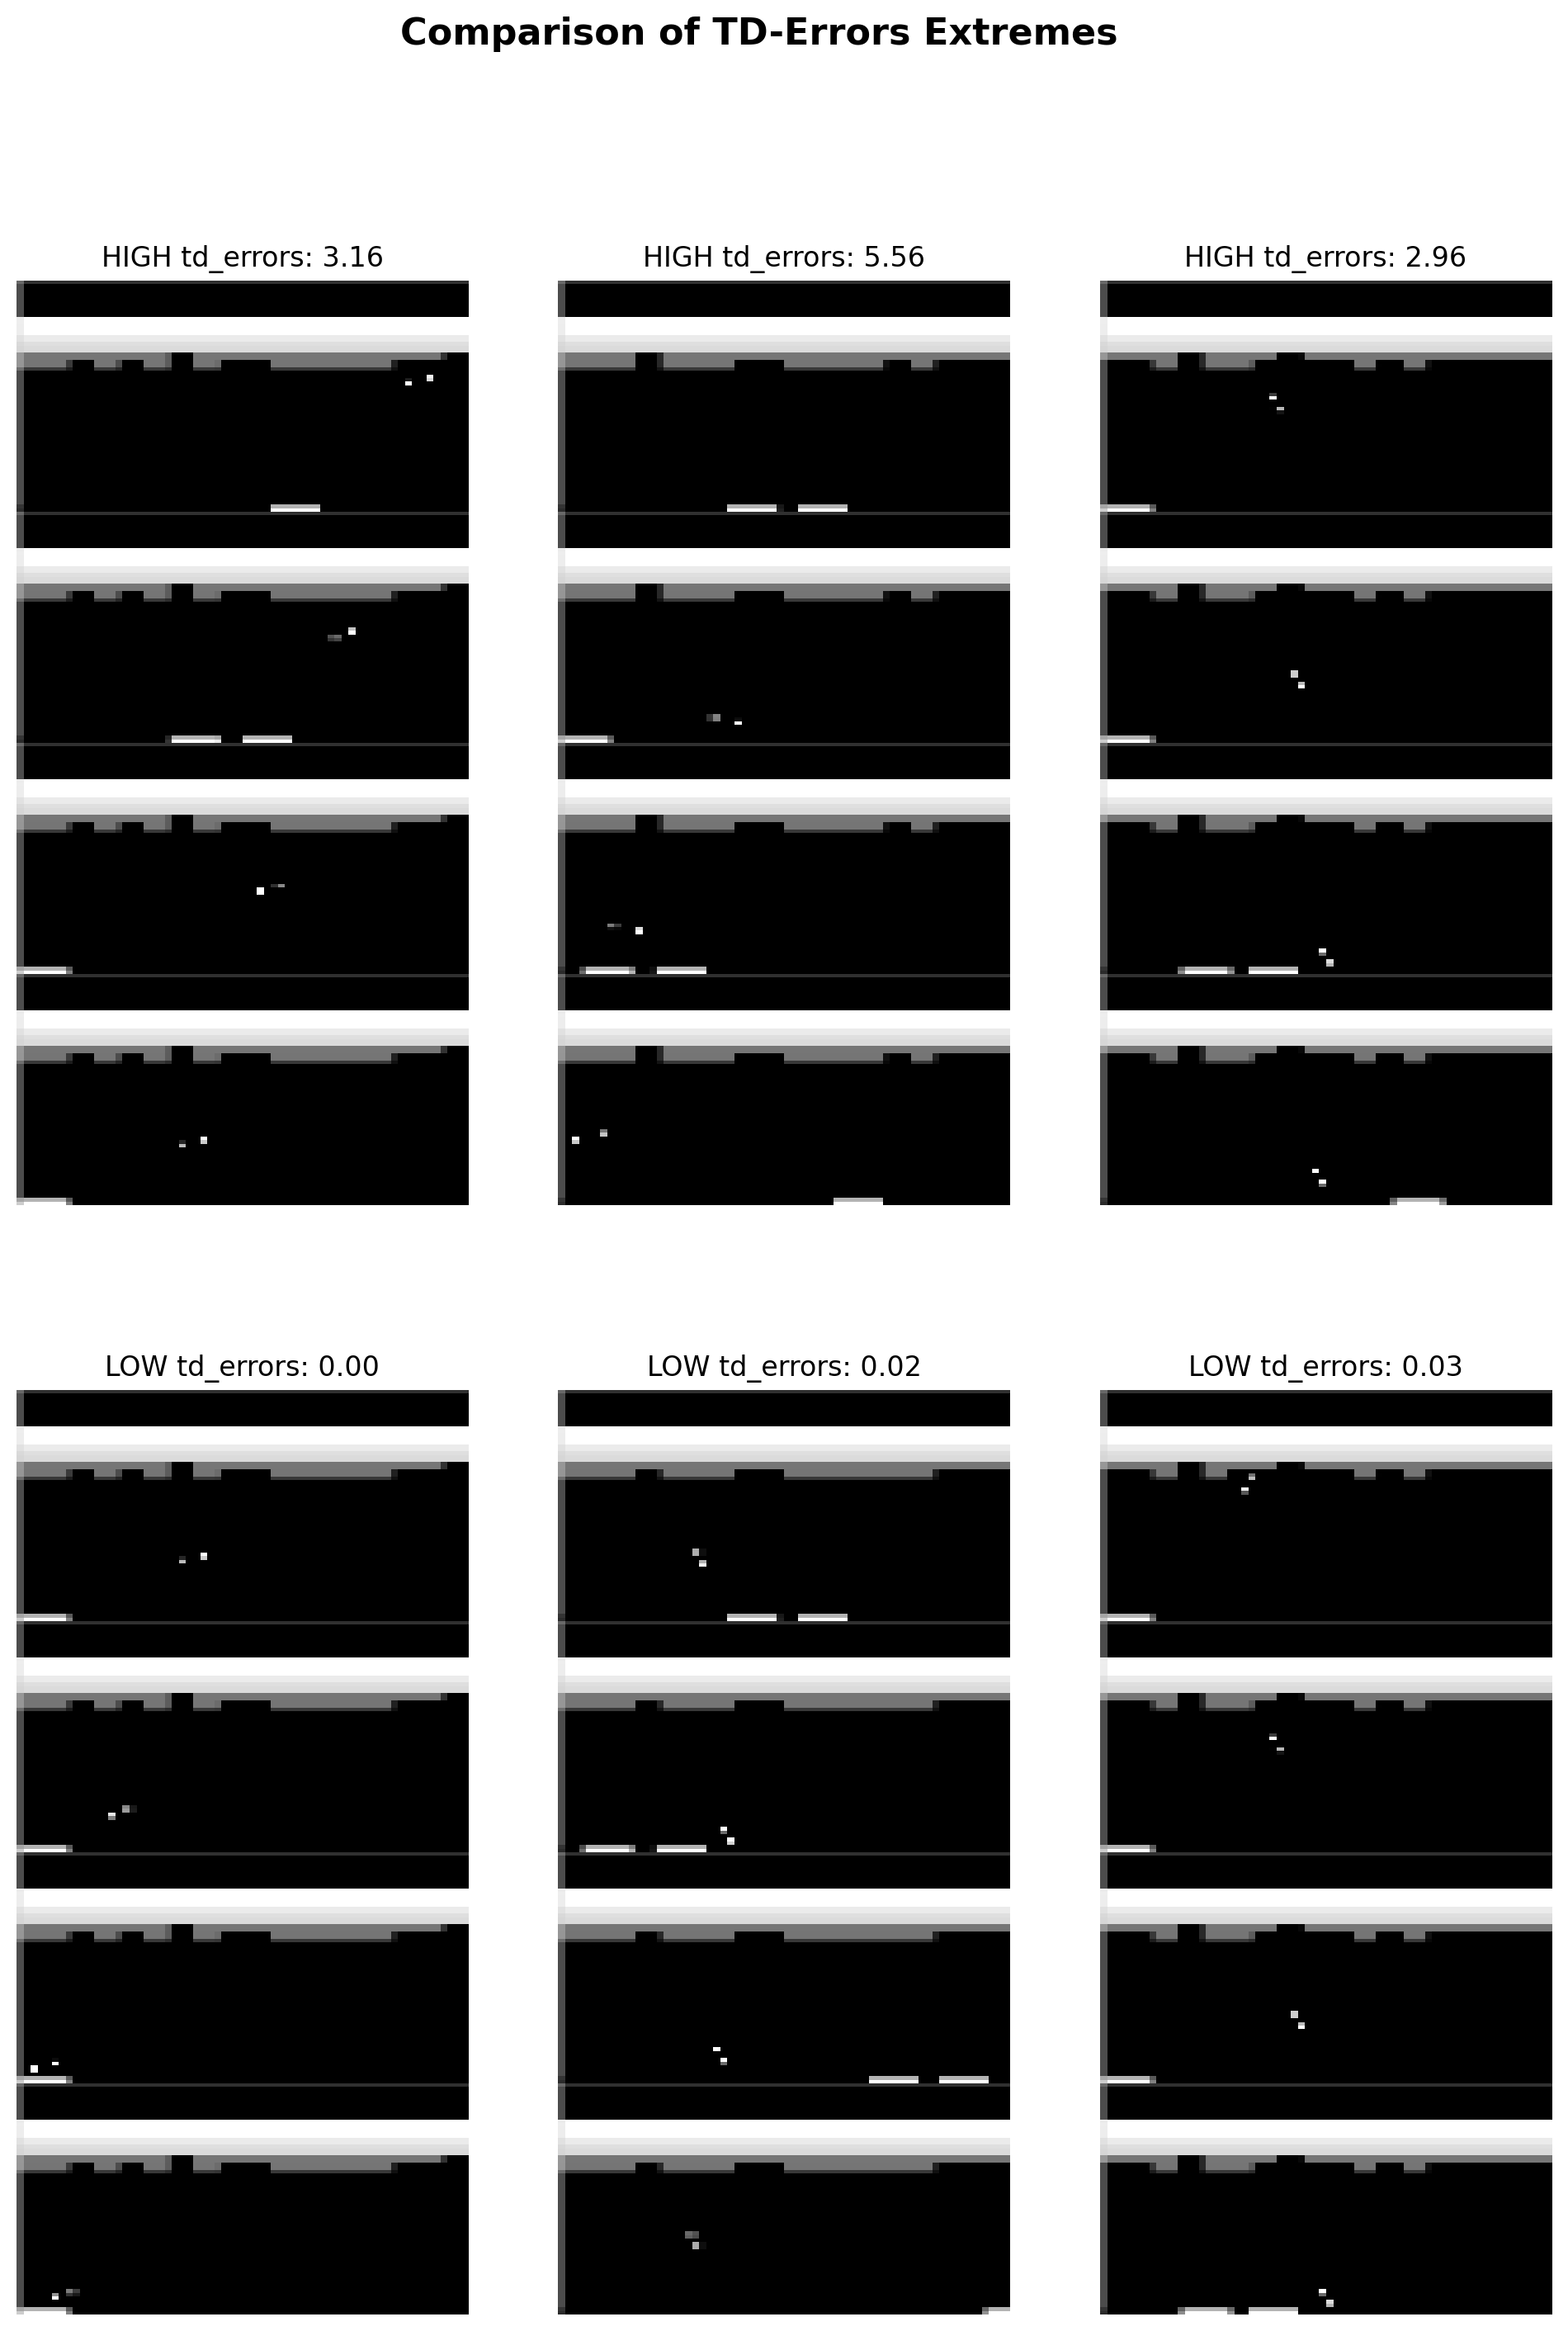

In [92]:
plot_high_low(eval_env, agent, "td_errors", "Comparison of TD-Errors Extremes")

Можно было бы предположить, что высокий TD-error будет там, где модель плохо обучилась и впервые встретила эту ситуацию, или ее можно назвать необычной для модели. Соттветственно низкий TD-Error там, где модель уже хорошо себе представляет, что происходит и встречала похожие ситуации. Но на картинках не особо это можно увидеть, по виду там высокая ошибка, когда модель что-то сделала неправильно и в процессе проигрыша. Низкая ошибка там, где модель в кадре от проигрыша, либо успешно отбила мяч.

# Bonus area
# Apply modifications to DQN

For inspiration see [Rainbow](https://arxiv.org/abs/1710.02298) - a version of q-learning that combines lots of them.

* [Quantile Regression DQN](https://arxiv.org/abs/1710.10044) (1.5 pt)
* [Prioritized Experience Replay](https://arxiv.org/abs/1710.10044) (2 pt)
* [n-step target without off-policy correction](https://arxiv.org/abs/1901.07510) (1 pt)
* [Clipped Double DQN](https://arxiv.org/abs/1802.09477v3) (0.5 pt)
* [Noisy networks](https://arxiv.org/abs/1706.10295) (1 pts)
* [DRQN](https://arxiv.org/abs/1507.06527) (3 pt)

## Quantile Regression DQN 

In [50]:
from src.DQN import conv2d_size_out, GradScalerFunctional, GradScaler
from src.QRDQN import QuantileDuelingNetwork, QuantileDQNAgent

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
device = torch.device("cuda:0")

In [51]:
env = make_env(seed)
state_shape = env.observation_space.shape
n_actions = env.action_space.n
state, _ = env.reset()

In [52]:
N_BINS = 5

agent = QuantileDQNAgent(state_shape, n_actions, n_bins=N_BINS, epsilon=1).to(device)
target_network = QuantileDQNAgent(state_shape, n_actions, n_bins=N_BINS).to(device)
target_network.load_state_dict(agent.state_dict())

<All keys matched successfully>

In [53]:
exp_replay = ReplayBuffer(10**5)
for i in range(100):
    if not utils.is_enough_ram(min_available_gb=0.1):
        print("""
            Less than 100 Mb RAM available.
            Make sure the buffer size in not too huge.
            Also check, maybe other processes consume RAM heavily.
            """)
        break
    play_and_record(state, agent, env, exp_replay, n_steps=10**2)
    if len(exp_replay) == 10**4:
        break
print(len(exp_replay))

10000


In [54]:
timesteps_per_epoch = 1
batch_size = 32
total_steps = 3 * 10**6
decay_steps = 10**6

opt = torch.optim.Adam(agent.parameters(), lr=1e-4)

init_epsilon = 1
final_epsilon = 0.1

loss_freq = 50
refresh_target_network_freq = 5000
eval_freq = 5000

max_grad_norm = 50

n_lives = 5

In [55]:
mean_rw_history = []
td_loss_history = []
grad_norm_history = []
initial_state_v_history = []

In [56]:
from src.utils import compute_quantile_loss

buffer size = 100000, epsilon = 0.10000


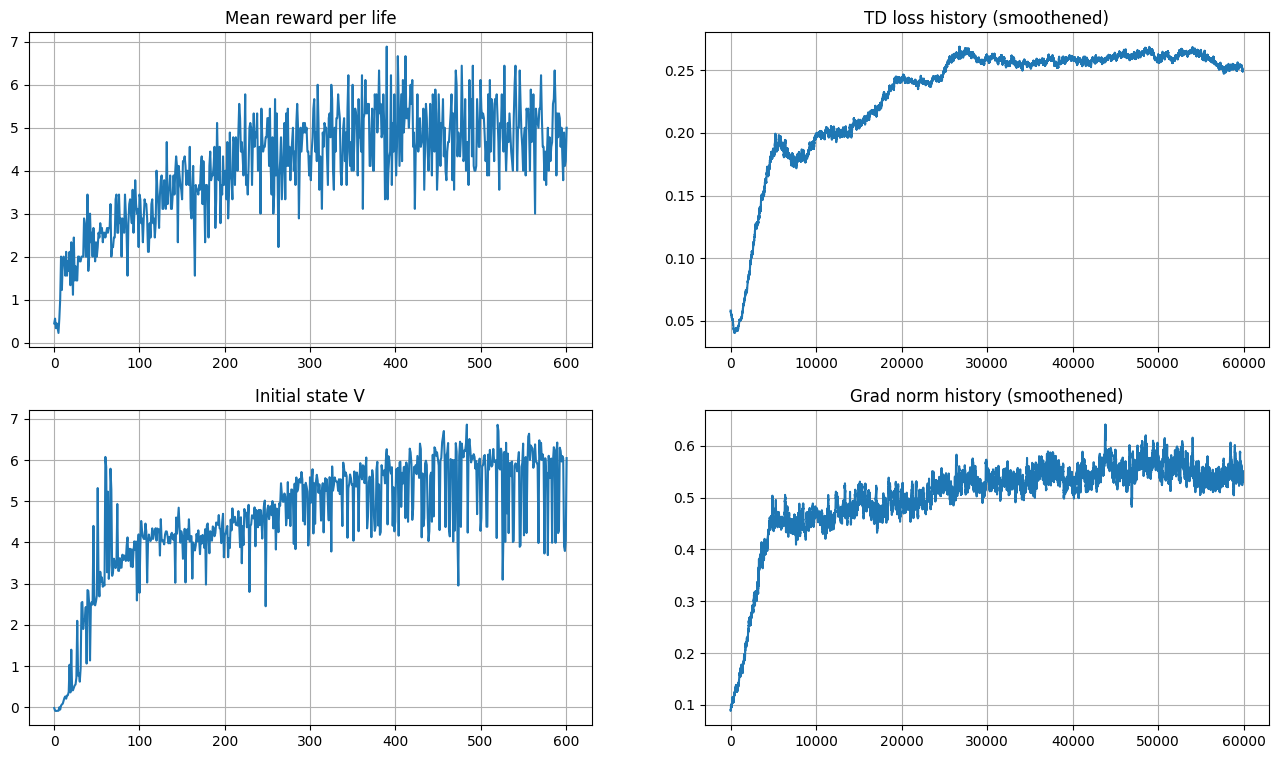

100%|████████████████████████████████████████████████████████████████████████████████████████████| 3000001/3000001 [6:50:00<00:00, 121.95it/s]


In [59]:
state, _ = env.reset()
for step in trange(total_steps + 1):
    if not utils.is_enough_ram():
        print('less that 100 Mb RAM available, freezing')
        print('make sure everything is ok and make KeyboardInterrupt to continue')
        try:
            while True:
                pass
        except KeyboardInterrupt:
            pass

    agent.epsilon = utils.linear_decay(init_epsilon, final_epsilon, step, decay_steps)

    # play
    _, state = play_and_record(state, agent, env, exp_replay, timesteps_per_epoch)

    # train
    obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(batch_size)

    loss = compute_quantile_loss(
        obs_batch,
        act_batch,
        reward_batch,
        next_obs_batch,
        is_done_batch,
        agent,
        target_network,
        gamma=0.99
    )

    opt.zero_grad(set_to_none=True)
    loss.backward()
    grad_norm = nn.utils.clip_grad_norm_(agent.parameters(), max_grad_norm)
    opt.step()

    if step % loss_freq == 0:
        td_loss_history.append(loss.data.cpu().item())
        grad_norm_history.append(grad_norm.cpu().item())

    if step % refresh_target_network_freq == 0:
        # Load agent weights into target_network
        # <YOUR_CODE>
        target_network.load_state_dict(agent.state_dict())

    if step % eval_freq == 0:
        mean_rw_history.append(
            evaluate(
                make_env(clip_rewards=True, seed=step),
                agent,
                n_games=3 * 3,
                greedy=True
            )
        )
        initial_state_q_values = agent.get_qvalues(
            [make_env(seed=step).reset()[0]]
        )
        initial_state_v_history.append(np.max(initial_state_q_values))

        clear_output(True)
        print("buffer size = %i, epsilon = %.5f" %
              (len(exp_replay), agent.epsilon))

        plt.figure(figsize=[16, 9])

        plt.subplot(2, 2, 1)
        plt.title("Mean reward per life")
        plt.plot(mean_rw_history)
        plt.grid()

        assert not np.isnan(td_loss_history[-1])
        plt.subplot(2, 2, 2)
        plt.title("TD loss history (smoothened)")
        plt.plot(utils.smoothen(td_loss_history))
        plt.grid()

        plt.subplot(2, 2, 3)
        plt.title("Initial state V")
        plt.plot(initial_state_v_history)
        plt.grid()

        plt.subplot(2, 2, 4)
        plt.title("Grad norm history (smoothened)")
        plt.plot(utils.smoothen(grad_norm_history))
        plt.grid()
        plt.show()

In [60]:
torch.save(agent.state_dict(), "weights/qr-dqn-agent.pt")
torch.save(target_network.state_dict(), "weights/qr-dqn-target.pt")

# agent.load_state_dict(torch.load("weights/qr-dqn-agent.pt"))
# target_network.load_state_dict(torch.load("weights/qr-dqn-target.pt"))

Resulting graph:

<!-- 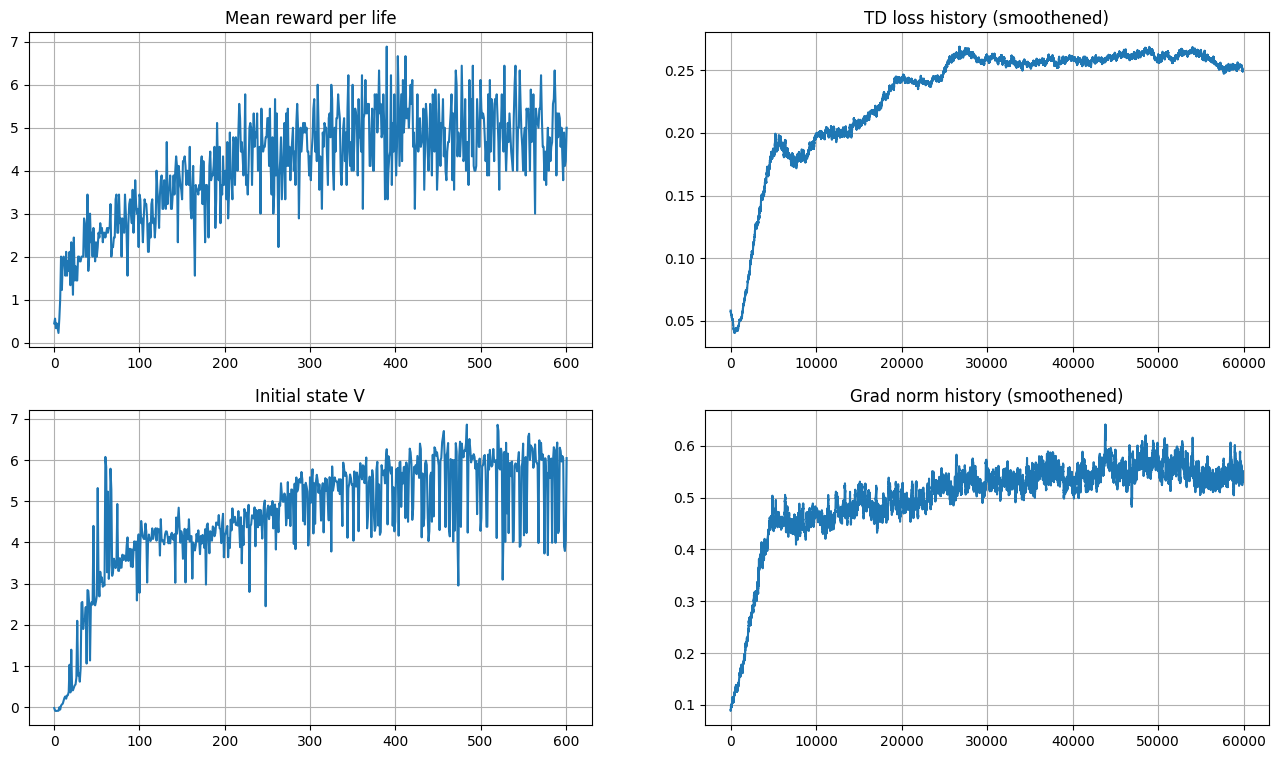 -->

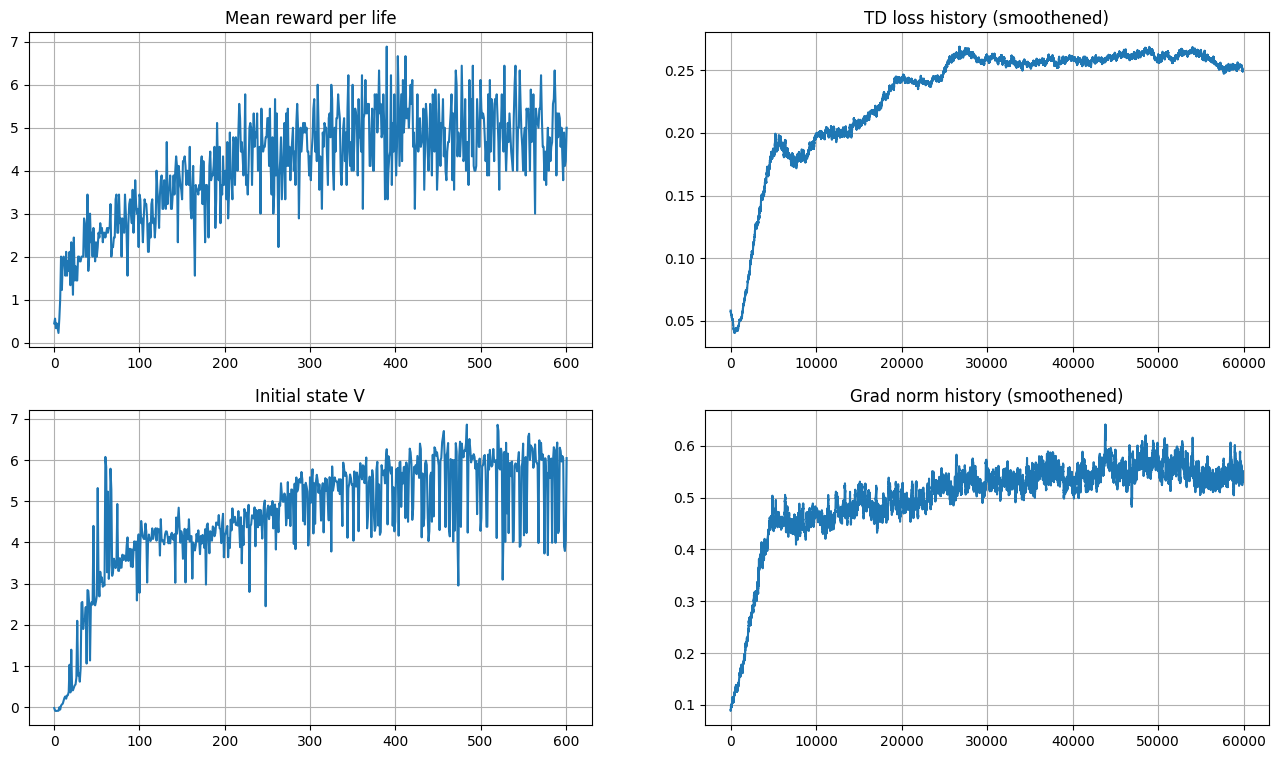

## Prioritized Experience Replay

In [1]:
import gc

gc.collect()

197

buffer size = 100000, epsilon = 0.74350


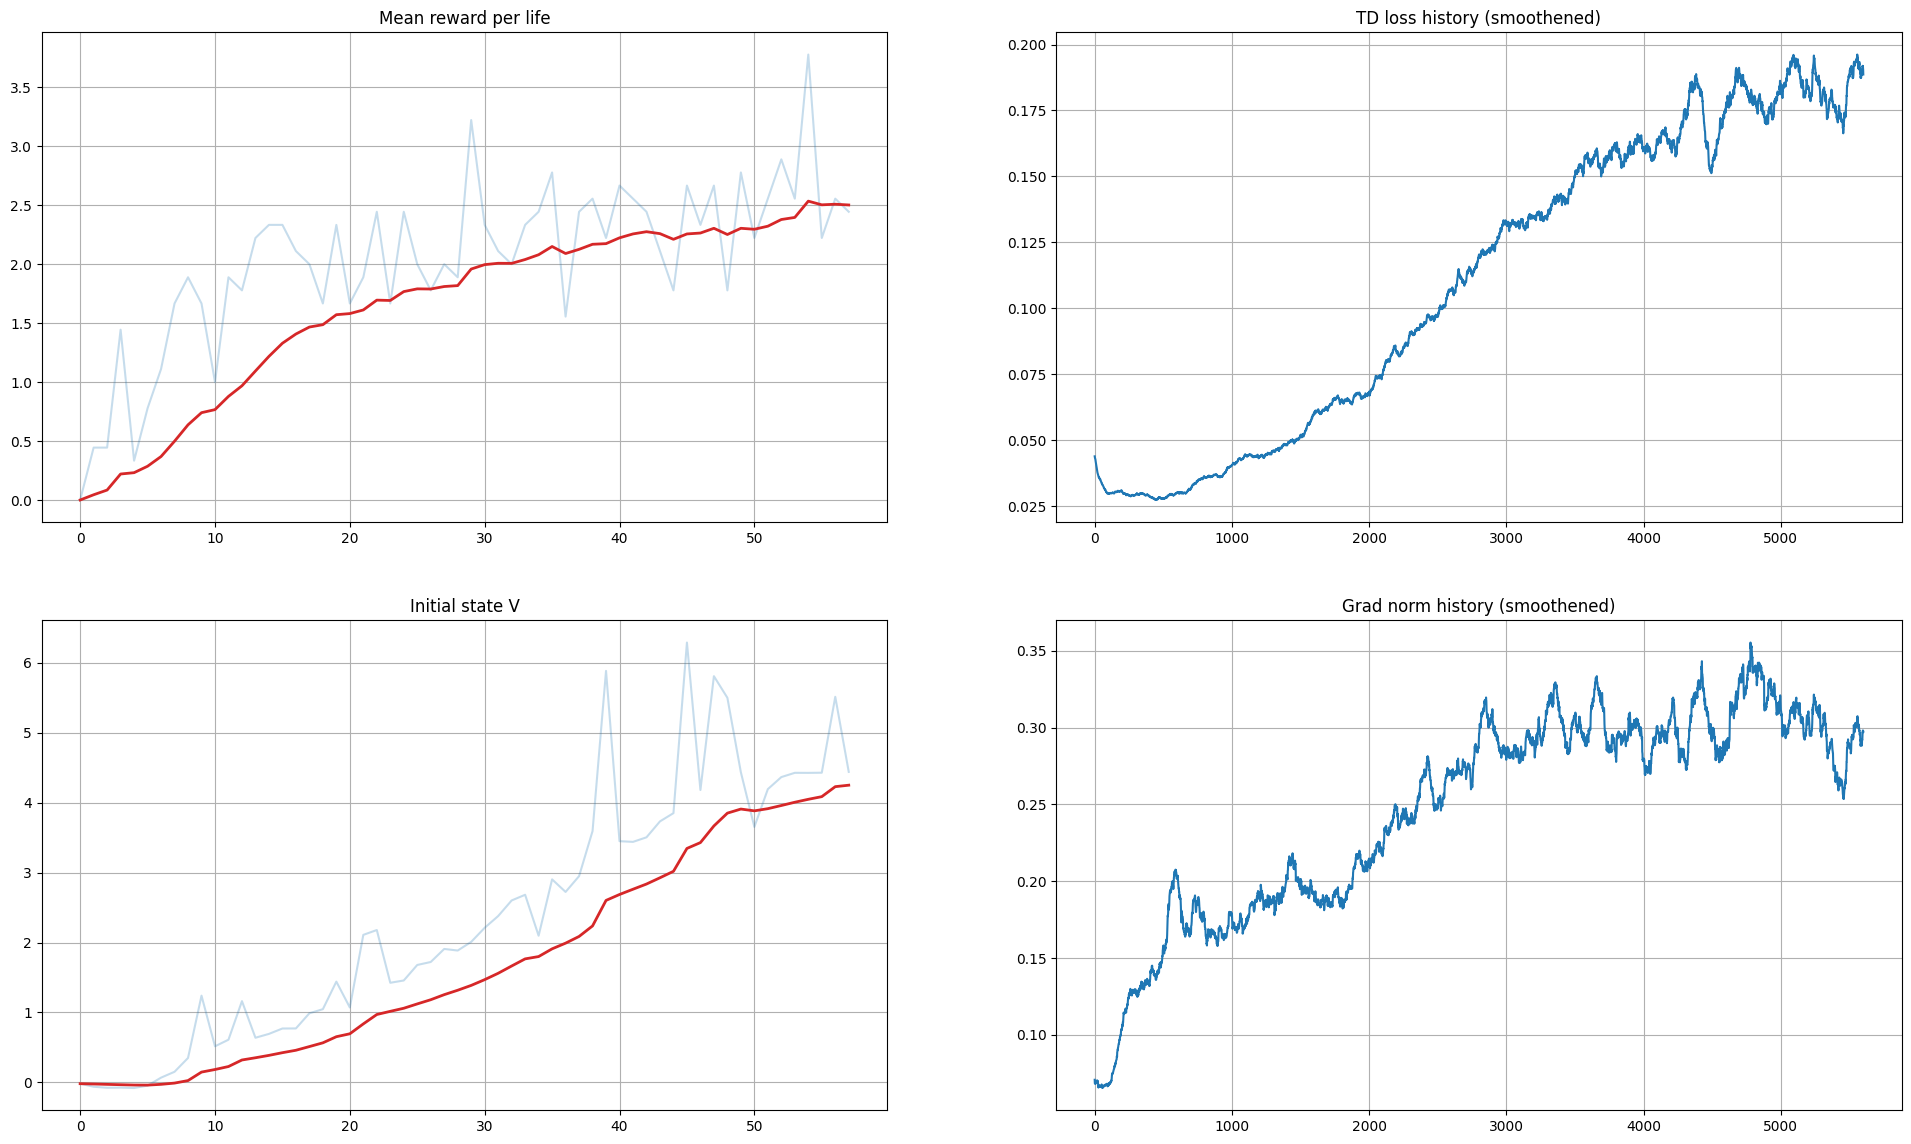

 10%|█████████▎                                                                                        | 286738/3000001 [46:08<7:16:35, 103.58it/s]


KeyboardInterrupt: 

In [2]:
%load_ext autoreload
%autoreload 2

from train import train

from tqdm import trange
import numpy as np
import torch
from torch import nn, t

import matplotlib.pyplot as plt
from IPython.display import clear_output

from utils_extra import make_env, play_and_record, evaluate, plot_stats, check_ram
from typing import Tuple
import utils

from src.QRDQN import QuantileDQNAgent
from src.utils import compute_quantile_loss
from src.replay_buffer import PrioritizedReplayBuffer
import random

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
device = torch.device("cuda:0")

env = make_env(seed=seed)
state_shape: Tuple[int, int, int] = env.observation_space.shape  # type: ignore
n_actions = env.action_space.n  # type: ignore

n_bins = 5

agent = QuantileDQNAgent(state_shape, n_actions, n_bins=n_bins, epsilon=1).to(device)
target_network = QuantileDQNAgent(state_shape, n_actions, n_bins=n_bins).to(device)
target_network.load_state_dict(agent.state_dict())

batch_size = 32
total_steps = 3_000_000
decay_steps = 1_000_000
play_n_steps = 1

optimizer = torch.optim.Adam(agent.parameters(), lr=1e-4)

init_epsilon = 1
final_epsilon = 0.1

loss_freq = 50
refresh_target_network_freq = 5_000
eval_freq = refresh_target_network_freq

max_grad_norm = 50

n_lives = 5

replay_buffer = PrioritizedReplayBuffer(100_000)

histories = train(
    agent=agent,
    target_network=target_network,
    optimizer=optimizer,
    max_grad_norm=max_grad_norm,
    loss_fn=compute_quantile_loss,
    env=env,
    total_steps=total_steps,
    replay_buffer=replay_buffer,
    batch_size=batch_size,
    decay_steps=decay_steps,
    init_epsilon=init_epsilon,
    final_epsilon=final_epsilon,
    loss_freq=loss_freq,
    refresh_target_network_freq=refresh_target_network_freq,
    eval_freq=eval_freq,
    play_n_steps=play_n_steps,
)

Видно, что в целом система работает, но интересно, что в Rainbow статье Prioritized Experience Replay на задаче breakout показывает результаты хуже, чем если использовать обычный replay buffer, так что может на других задачах это даст больше прирост в скорости обучения. Здесь также стоит учесть, что время итерации значительно воросло 130it/s -> 100it/sec, из-за наивного сэмплинга через numpy random choice. Так что лучше буду использовать обычный ExperienceReplay.

## QR-DQN hyperopt

buffer size = 100000, epsilon = 0.10000


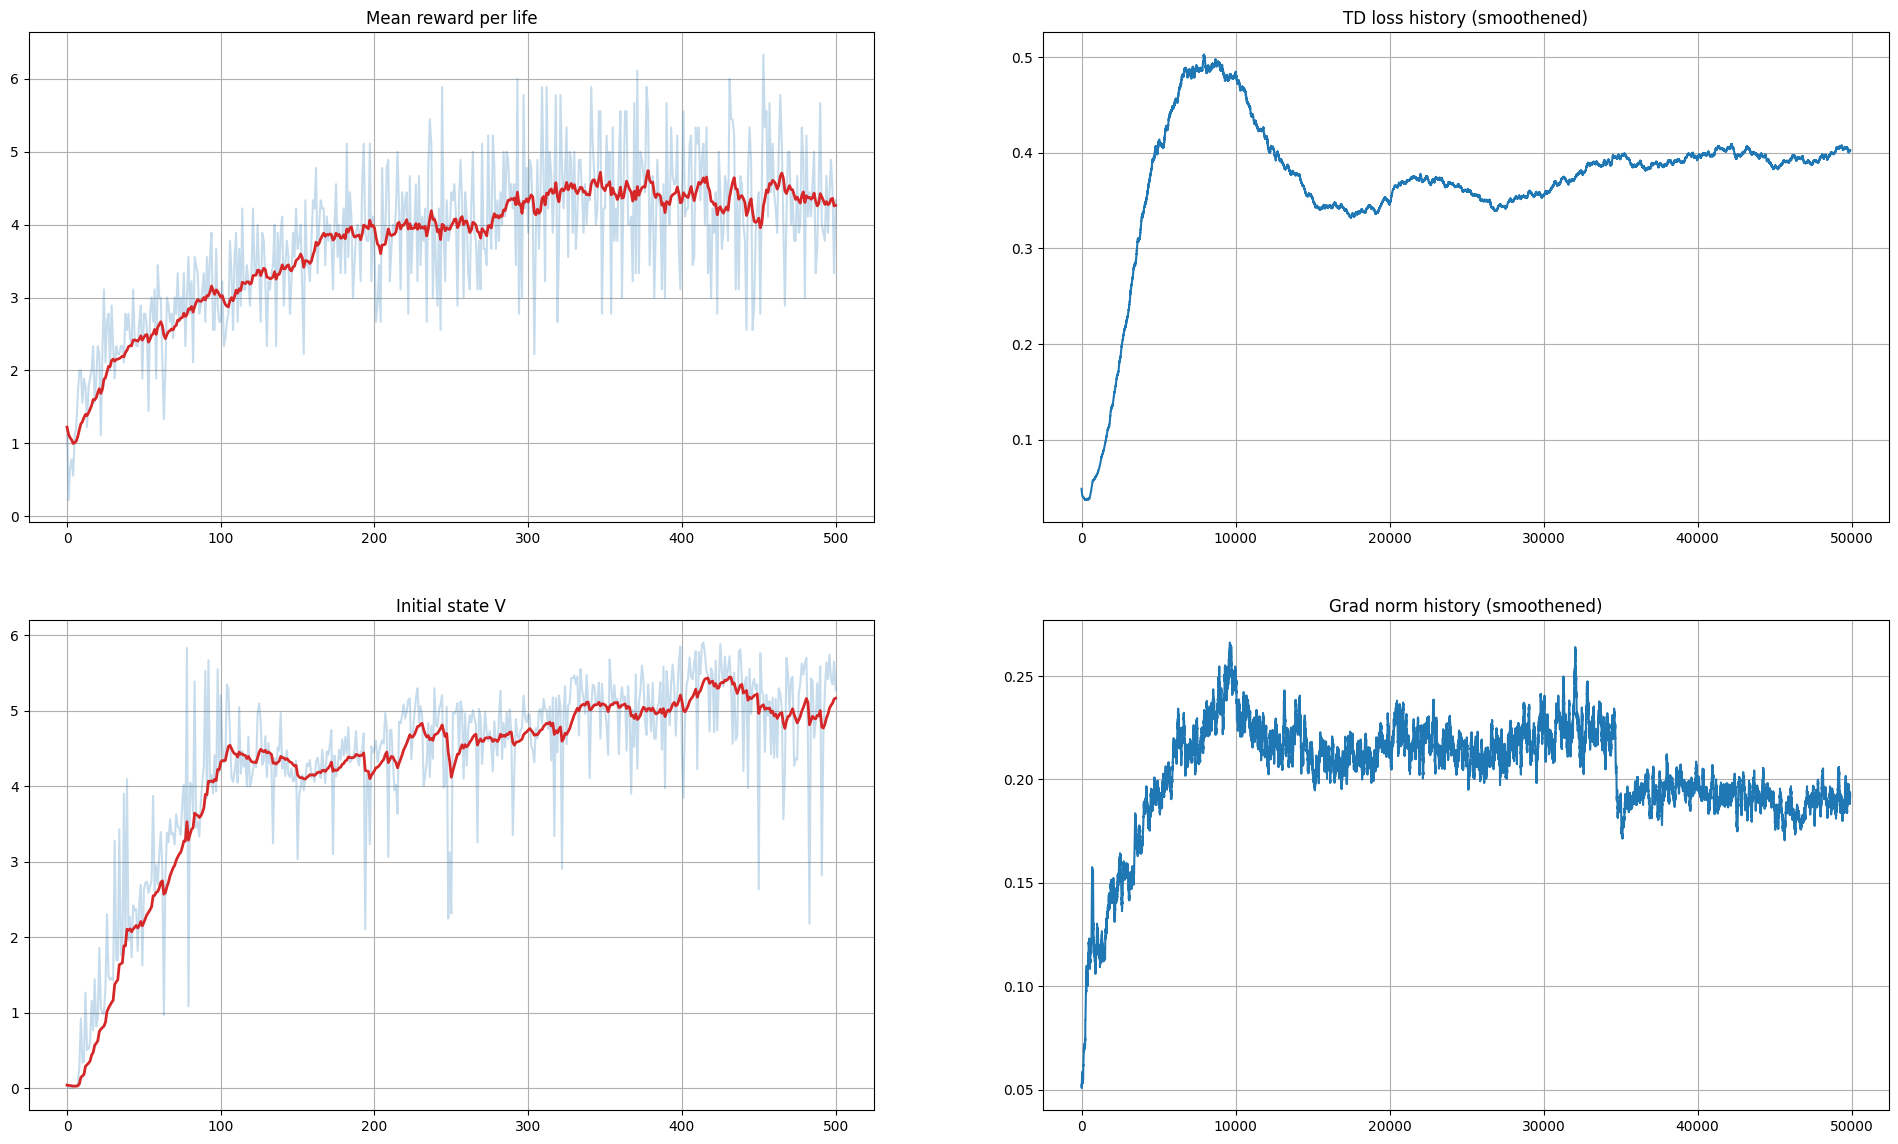

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1000001/1000001 [5:56:45<00:00, 46.72it/s]


In [5]:
%load_ext autoreload
%autoreload 2

from train import train

from tqdm import trange
import numpy as np
import torch
from torch import nn, t

import matplotlib.pyplot as plt
from IPython.display import clear_output

from utils_extra import make_env, play_and_record, evaluate, plot_stats, check_ram
from typing import Tuple
import utils

from src.QRDQN import QuantileDQNAgent
from src.utils import compute_quantile_loss
# from src.replay_buffer import PrioritizedReplayBuffer
from src.replay_buffer import ReplayBuffer
import random

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
device = torch.device("cuda:0")

env = make_env(seed=seed)
state_shape: Tuple[int, int, int] = env.observation_space.shape
n_actions = env.action_space.n

n_bins = 25  # 5 -> 25

agent = QuantileDQNAgent(state_shape, n_actions, n_bins=n_bins, epsilon=1).to(device)
target_network = QuantileDQNAgent(state_shape, n_actions, n_bins=n_bins).to(device)
target_network.load_state_dict(agent.state_dict())

batch_size = 128  # 32 -> 128
total_steps = 1_000_000  # 3e6 -> 1e6
decay_steps = 300_000  # 1e6 -> 3e5
play_n_steps = 4  # 1 -> 4

optimizer = torch.optim.Adam(agent.parameters(), lr=2e-4)  # lr 1e-4 -> 2e-4

init_epsilon = 1
final_epsilon = 0.1

loss_freq = 20  # 50 -> 20
refresh_target_network_freq = 2_000  # 5_000 -> 2_000
eval_freq = 2_000  # 5_000 -> 2_000

max_grad_norm = 50

n_lives = 5

replay_buffer = ReplayBuffer(100_000)  # PrioritizedReplayBuffer -> ReplayBuffer

histories = train(
    agent=agent,
    target_network=target_network,
    optimizer=optimizer,
    max_grad_norm=max_grad_norm,
    loss_fn=compute_quantile_loss,
    env=env,
    total_steps=total_steps,
    replay_buffer=replay_buffer,
    batch_size=batch_size,
    decay_steps=decay_steps,
    init_epsilon=init_epsilon,
    final_epsilon=final_epsilon,
    loss_freq=loss_freq,
    refresh_target_network_freq=refresh_target_network_freq,
    eval_freq=eval_freq,
    play_n_steps=play_n_steps,
)

Будем считать, что проблема с PrioritizedExperienceReplay

## Noisy networks

buffer size = 100000, epsilon = 0.00000


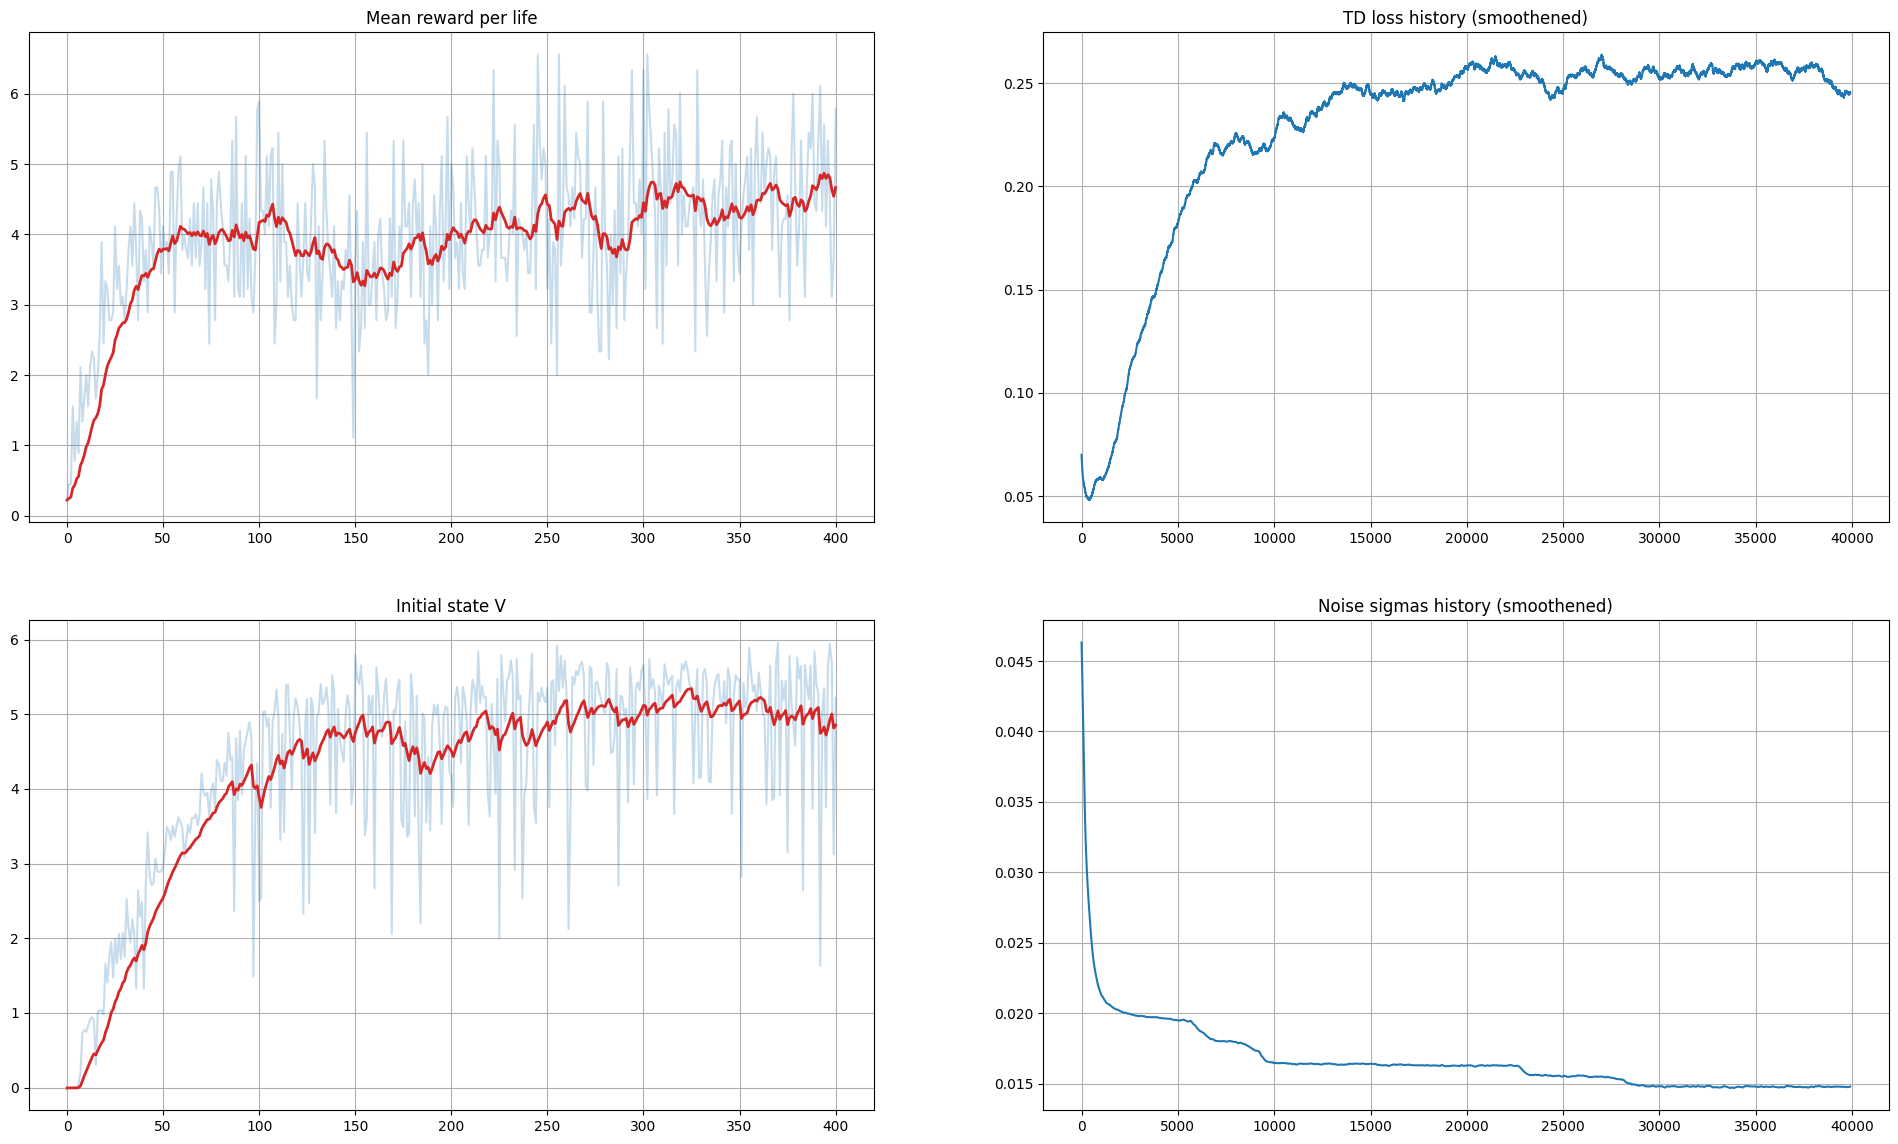

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 800001/800001 [5:02:44<00:00, 44.04it/s]


In [1]:
%load_ext autoreload
%autoreload 2

from train import train

from tqdm import trange
import numpy as np
import torch
from torch import nn, t

import matplotlib.pyplot as plt
from IPython.display import clear_output

from utils_extra import make_env, play_and_record, evaluate, plot_stats, check_ram
from typing import Tuple
import utils

from src.QRDQN import QuantileDQNAgent
from src.utils import compute_quantile_loss
# from src.replay_buffer import PrioritizedReplayBuffer
from src.replay_buffer import ReplayBuffer
import random

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
device = torch.device("cuda:0")

env = make_env(seed=seed)
state_shape: Tuple[int, int, int] = env.observation_space.shape
n_actions = env.action_space.n

n_bins = 25

agent = QuantileDQNAgent(state_shape, n_actions, n_bins=n_bins, epsilon=1).to(device)
target_network = QuantileDQNAgent(state_shape, n_actions, n_bins=n_bins).to(device)
target_network.load_state_dict(agent.state_dict())

batch_size = 128
total_steps = 800_000  # 1e6 -> 8e5
decay_steps = 300_000
play_n_steps = 4

optimizer = torch.optim.Adam(agent.parameters(), lr=2e-4)

init_epsilon = 0
final_epsilon = 0

loss_freq = 20
refresh_target_network_freq = 2_000
eval_freq = 2_000

max_grad_norm = 50

n_lives = 5

replay_buffer = ReplayBuffer(100_000)

histories = train(
    agent=agent,
    target_network=target_network,
    optimizer=optimizer,
    max_grad_norm=max_grad_norm,
    loss_fn=compute_quantile_loss,
    env=env,
    total_steps=total_steps,
    replay_buffer=replay_buffer,
    batch_size=batch_size,
    decay_steps=decay_steps,
    init_epsilon=init_epsilon,
    final_epsilon=final_epsilon,
    loss_freq=loss_freq,
    refresh_target_network_freq=refresh_target_network_freq,
    eval_freq=eval_freq,
    play_n_steps=play_n_steps,
)

Интересная картина, не знаю, с чем это может быть связано, но перформанс начинает довольно быстро деградировать. Также мне кажется довольно нестабильной идея влиять на exploration через добавления этого шума с параметрами, которые выучивает модель. Как будто она довольно быстро должна научиться просто занулять эти коэффициенты, и по графику видно, что она практически сразу снизила дисперсию до 2%, что как будто не будет давать нам достаточно отклонения от жадной стратегии.

Вот результаты из Rainbow:

Вернхняя линия - Rainbow, нижняя - DQN, столбик это перформанс БЕЗ какой-то фичи.

![breakout](./plots/breakout-rainbow.png)

Так что не хочется делать multi-step, так как скорее всего на перформансе это отразится отрицательно.